# Architecture Diagrams: FNN Cone, GRU, OLS Regression

Visual representations of the three deep hedging models used in the MSc thesis.

- **FNN**: Cone architecture (narrowing hidden layers), CELU activations, 1 output → sigmoid allocation
- **GRU**: Pre-MLP → stacked GRU → head MLP, d_traded=2 outputs → direct hedge positions
- **OLS Regression**: Closed-form linear model, d_traded=2 outputs → direct hedge positions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

## 1. FNN Cone Hedger

Narrowing "cone" feedforward network. At each time step $k$, maps features $X_k \in \mathbb{R}^8$ (log-prices, time-to-maturity, signatures) to a **single** logit $h_k$. Portfolio allocation via $w_1 = \sigma(h_k)$, $w_2 = 1 - w_1$.

**Architecture**: `start_width → start_width//2 → ... → 4 → 1`  
**Block**: Linear → LayerNorm → CELU → Dropout  
**Output head**: Linear(last_width, 1) — identity (no activation)

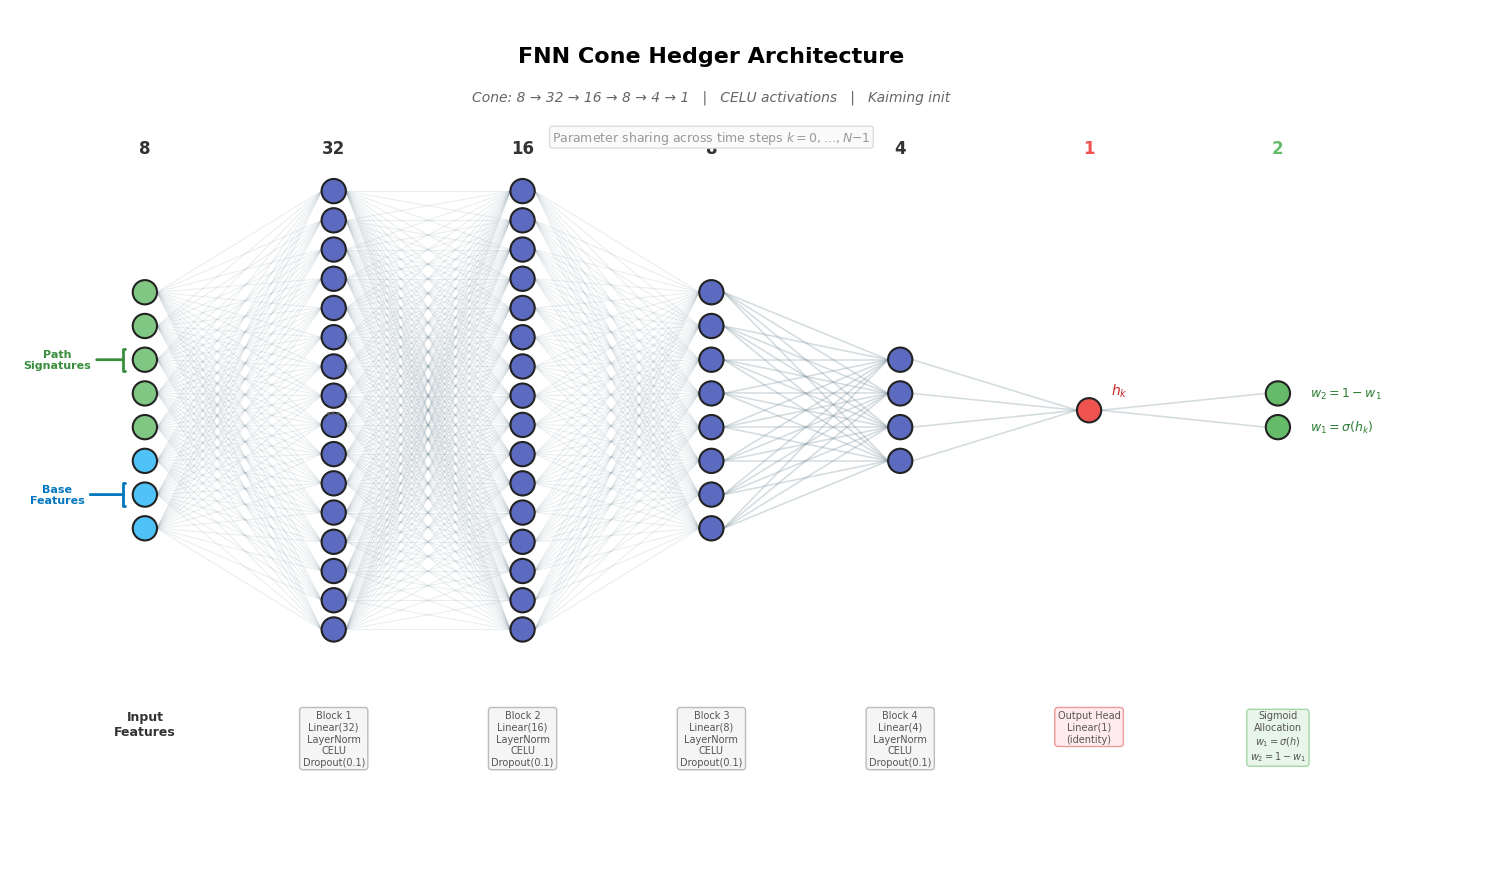

In [2]:
def draw_fnn_cone(save_path=None, start_width=32):
    """Draw FNN Cone hedger with individual neurons and connections.
    
    Style: neuron circles, grouped inputs, connection lines, block labels.
    Cone: 8 -> 32 -> 16 -> 8 -> 4 -> 1 (-> sigmoid allocation)
    """
    # Compute cone widths
    widths = []
    w = start_width
    while w >= 4:
        widths.append(w)
        w = w // 2

    # Layer sizes: input, hidden cone layers, output head, sigmoid output
    input_size = 8
    output_size = 1
    alloc_size = 2
    layer_sizes = [input_size] + widths + [output_size, alloc_size]
    n_layers = len(layer_sizes)

    # Max neurons to draw per layer (show dots for large layers)
    max_draw = 16  # draw up to this many, with dots for the rest

    fig, ax = plt.subplots(figsize=(20, 9))

    # Spacing
    x_spacing = 2.8
    total_width = (n_layers - 1) * x_spacing
    x_start = 1.5
    y_center = 4.0
    neuron_radius = 0.18
    max_y_span = 6.5

    # Colours
    c_base = '#4FC3F7'       # light blue - base features
    c_sig = '#81C784'        # green - signatures
    c_hidden = '#5C6BC0'     # indigo - hidden
    c_output = '#EF5350'     # red - output
    c_alloc = '#66BB6A'      # green - allocation
    c_conn = '#78909C'       # stronger grey connections
    c_conn_out = '#90A4AE'

    def get_neuron_positions(layer_idx, size):
        """Get (x, [y1, y2, ...]) positions for neurons in a layer."""
        x = x_start + layer_idx * x_spacing
        draw_n = min(size, max_draw)
        if draw_n <= 1:
            return x, [y_center]
        spacing = min(0.5, max_y_span / (draw_n - 1))
        total_h = (draw_n - 1) * spacing
        ys = [y_center - total_h/2 + i * spacing for i in range(draw_n)]
        return x, ys

    all_positions = []
    for i, size in enumerate(layer_sizes):
        x, ys = get_neuron_positions(i, size)
        all_positions.append((x, ys, size))

    # --- Draw connections (THICKER) ---
    for l in range(n_layers - 1):
        x1, ys1, s1 = all_positions[l]
        x2, ys2, s2 = all_positions[l + 1]
        alpha = 0.15 if max(s1, s2) > 10 else 0.3
        lw = 0.8 if max(s1, s2) > 10 else 1.2
        for y1 in ys1:
            for y2 in ys2:
                ax.plot([x1 + neuron_radius, x2 - neuron_radius], [y1, y2],
                        color=c_conn, linewidth=lw, alpha=alpha, zorder=0)

    # --- Draw neurons (THICKER edges) ---
    for l, (x, ys, size) in enumerate(all_positions):
        draw_n = min(size, max_draw)
        show_dots = size > max_draw

        if l == 0:
            # Input layer: colour-code base vs signatures
            colours = [c_base] * 3 + [c_sig] * 5
        elif l <= len(widths):
            colours = [c_hidden] * draw_n
        elif l == len(widths) + 1:
            colours = [c_output] * draw_n
        else:
            colours = [c_alloc] * draw_n

        for i, y in enumerate(ys):
            circle = plt.Circle((x, y), neuron_radius, facecolor=colours[min(i, len(colours)-1)],
                               edgecolor='#222', linewidth=1.5, zorder=3)
            ax.add_patch(circle)

        # Dots indicator for truncated layers
        if show_dots:
            mid_y = y_center
            ax.text(x, mid_y, '...', ha='center', va='center', fontsize=10,
                    fontweight='bold', color='#555', zorder=4)

    # --- Layer labels (bottom) ---
    label_y = y_center - max_y_span/2 - 1.2
    # Input
    x0 = all_positions[0][0]
    ax.text(x0, label_y, 'Input\nFeatures', ha='center', va='top',
            fontsize=9, fontweight='bold', color='#333')

    # Hidden blocks
    for i, width in enumerate(widths):
        xh = all_positions[i + 1][0]
        ax.text(xh, label_y, f'Block {i+1}\nLinear({width})\nLayerNorm\nCELU\nDropout(0.1)',
                ha='center', va='top', fontsize=7, color='#555',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#F5F5F5',
                         edgecolor='#BBB', linewidth=1.0))

    # Output head
    x_out = all_positions[len(widths) + 1][0]
    ax.text(x_out, label_y, 'Output Head\nLinear(1)\n(identity)',
            ha='center', va='top', fontsize=7, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFEBEE',
                     edgecolor='#EF9A9A', linewidth=1.0))

    # Sigmoid allocation
    x_alloc = all_positions[-1][0]
    ax.text(x_alloc, label_y, 'Sigmoid\nAllocation\n$w_1=\\sigma(h)$\n$w_2=1-w_1$',
            ha='center', va='top', fontsize=7, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#E8F5E9',
                     edgecolor='#A5D6A7', linewidth=1.0))

    # --- Size labels above each layer ---
    top_y = y_center + max_y_span/2 + 0.5
    for l, (x, ys, size) in enumerate(all_positions):
        if l == 0:
            lbl = '8'
        elif l <= len(widths):
            lbl = str(widths[l-1])
        elif l == len(widths) + 1:
            lbl = '1'
        else:
            lbl = '2'
        c = c_output if l == len(widths) + 1 else ('#333' if l <= len(widths) else c_alloc)
        ax.text(x, top_y, lbl, ha='center', va='bottom', fontsize=12,
                fontweight='bold', color=c)

    # --- Input feature group labels (THICKER brackets) ---
    x_inp = all_positions[0][0]
    ys_inp = all_positions[0][1]
    # Base features (first 3)
    base_mid = np.mean(ys_inp[:3])
    ax.annotate('Base\nFeatures',
                xy=(x_inp - neuron_radius - 0.1, base_mid),
                xytext=(x_inp - 1.3, base_mid),
                ha='center', va='center', fontsize=8, color='#0277BD', fontweight='bold',
                arrowprops=dict(arrowstyle='-[', color='#0277BD', lw=2.0))
    # Signatures (last 5)
    sig_mid = np.mean(ys_inp[3:])
    ax.annotate('Path\nSignatures',
                xy=(x_inp - neuron_radius - 0.1, sig_mid),
                xytext=(x_inp - 1.3, sig_mid),
                ha='center', va='center', fontsize=8, color='#388E3C', fontweight='bold',
                arrowprops=dict(arrowstyle='-[', color='#388E3C', lw=2.0))

    # --- Output labels ---
    x_alloc_pos = all_positions[-1][0]
    ys_alloc = all_positions[-1][1]
    ax.text(x_alloc_pos + neuron_radius + 0.3, ys_alloc[0], '$w_1 = \\sigma(h_k)$',
            ha='left', va='center', fontsize=9, fontweight='bold', color='#2E7D32')
    ax.text(x_alloc_pos + neuron_radius + 0.3, ys_alloc[1], '$w_2 = 1 - w_1$',
            ha='left', va='center', fontsize=9, fontweight='bold', color='#2E7D32')

    # h_k label on output neuron
    x_h = all_positions[-2][0]
    ys_h = all_positions[-2][1]
    ax.text(x_h + neuron_radius + 0.15, ys_h[0] + 0.3, '$h_k$',
            ha='left', va='center', fontsize=10, fontweight='bold', color='#C62828')

    # --- Title ---
    title_x = x_start + total_width / 2
    ax.text(title_x, top_y + 1.5,
            f'FNN Cone Hedger Architecture',
            ha='center', va='center', fontsize=16, fontweight='bold')
    widths_str = ' → '.join(str(w) for w in widths)
    ax.text(title_x, top_y + 0.9,
            f'Cone: 8 → {widths_str} → 1   |   CELU activations   |   Kaiming init',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    # Parameter sharing note
    ax.text(title_x, top_y + 0.3,
            'Parameter sharing across time steps $k = 0, \\ldots, N{-}1$',
            ha='center', va='center', fontsize=9, color='#999',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='#FAFAFA',
                     edgecolor='#DDD', linewidth=1.0))

    ax.set_xlim(-0.5, x_start + total_width + 3)
    ax.set_ylim(label_y - 2.5, top_y + 2.2)
    ax.set_aspect('equal')
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_fnn_cone('Figures/fnn_cone_architecture.png', start_width=32)

## 2. GRU Hedger

Pre-MLP $\to$ stacked GRU $\to$ Head MLP. Processes the feature sequence causally and outputs **direct hedge positions** $h_k \in \mathbb{R}^2$ at each step. Gains: $g_k = h_k \odot \Delta S_k$.

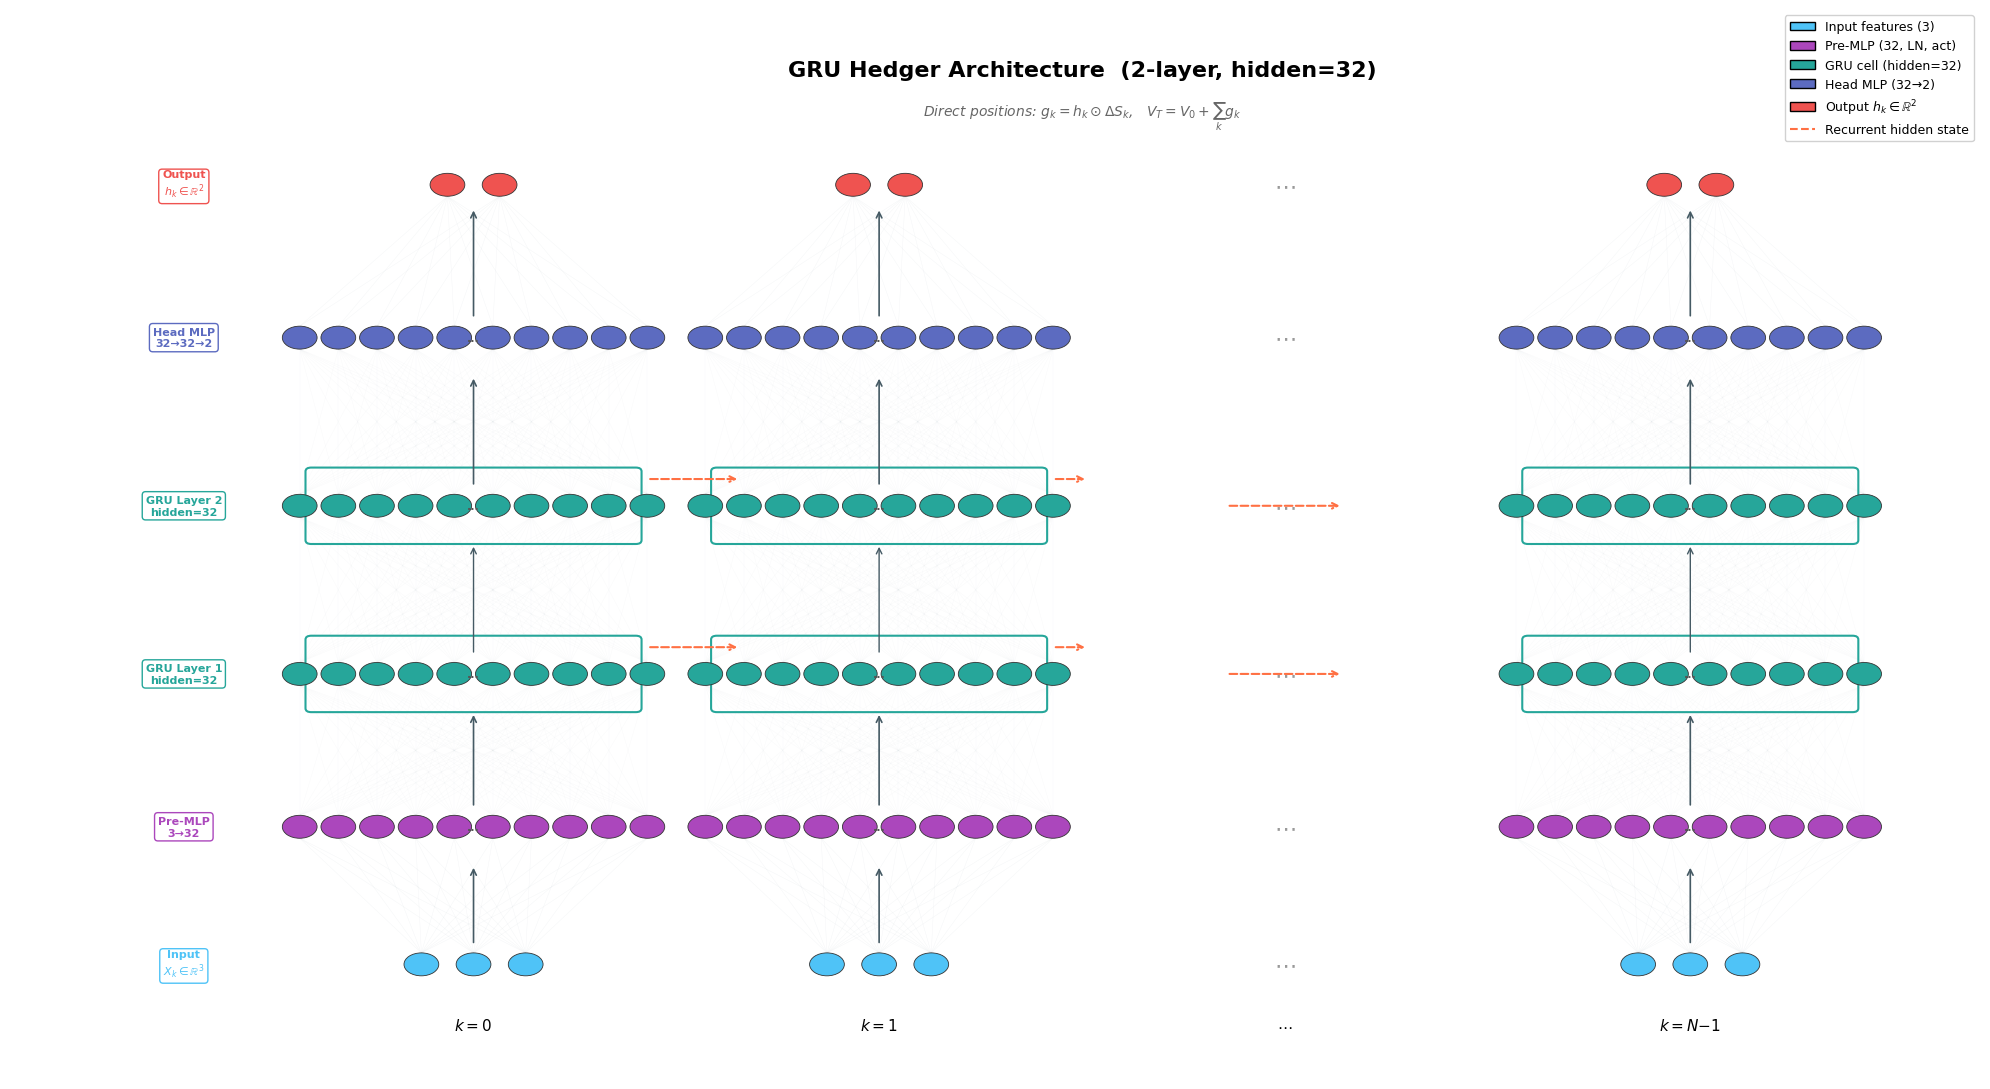

In [3]:
def draw_gru(save_path=None, num_layers=2, hidden_size=32):
    """Draw GRU hedger with neuron-level detail.
    
    Shows unrolled time steps with Pre-MLP, stacked GRU cells, Head MLP.
    Input 3 -> Pre-MLP -> hidden -> GRU layers -> Head -> 2 direct positions.
    """
    fig, ax = plt.subplots(figsize=(20, 11))

    # Layout parameters
    col_spacing = 3.5
    time_labels = ['$k=0$', '$k=1$', '$\\cdots$', '$k=N{-}1$']
    n_cols = len(time_labels)

    # Vertical positions for each stage
    input_y = 0.0
    pre_y = 1.8
    gru_ys = [pre_y + 2.0 + i * 2.2 for i in range(num_layers)]
    head_y = gru_ys[-1] + 2.2
    output_y = head_y + 2.0

    neuron_r = 0.15
    x_start = 2.0

    # Colours
    c_input = '#4FC3F7'
    c_pre = '#AB47BC'
    c_gru = '#26A69A'
    c_head = '#5C6BC0'
    c_output = '#EF5350'
    c_conn = '#B0BEC5'
    c_recur = '#FF7043'

    def draw_neuron_row(ax, cx, cy, n, max_n, colour, label=None):
        """Draw a horizontal row of neurons centered at (cx, cy)."""
        draw_n = min(n, max_n)
        spacing = min(0.45, 3.0 / max(draw_n - 1, 1))
        total_w = (draw_n - 1) * spacing
        xs = [cx - total_w/2 + i * spacing for i in range(draw_n)]
        for x in xs:
            circle = plt.Circle((x, cy), neuron_r, facecolor=colour,
                               edgecolor='#333', linewidth=0.6, zorder=3)
            ax.add_patch(circle)
        if n > max_n:
            ax.text(cx, cy, '...', ha='center', va='center', fontsize=8,
                    fontweight='bold', color='#555', zorder=4)
        if label:
            ax.text(cx, cy - 0.6, label, ha='center', va='top', fontsize=7,
                    color='#555')
        return xs

    def draw_vertical_connections(ax, xs_from, y_from, xs_to, y_to, colour=c_conn, alpha=0.1):
        """Draw connections between two neuron rows."""
        for x1 in xs_from:
            for x2 in xs_to:
                ax.plot([x1, x2], [y_from + neuron_r, y_to - neuron_r],
                        color=colour, linewidth=0.3, alpha=alpha, zorder=0)

    for col_idx in range(n_cols):
        cx = x_start + col_idx * col_spacing
        is_dots = (col_idx == 2)

        if is_dots:
            # Just draw dots at each level
            for y in [input_y, pre_y] + gru_ys + [head_y, output_y]:
                ax.text(cx, y, '$\\cdots$', ha='center', va='center',
                        fontsize=16, color='#999', fontweight='bold')
            ax.text(cx, input_y - 0.8, time_labels[col_idx],
                    ha='center', va='center', fontsize=11)
            # Recurrent arrows through dots
            for gy in gru_ys:
                ax.annotate('', xy=(cx + 0.5, gy),
                            xytext=(cx - 0.5, gy),
                            arrowprops=dict(arrowstyle='->', color=c_recur,
                                            lw=1.5, linestyle='--'))
            continue

        # --- Input neurons ---
        xs_inp = draw_neuron_row(ax, cx, input_y, 3, 3, c_input)

        # Arrow input -> pre-MLP
        ax.annotate('', xy=(cx, pre_y - 0.5), xytext=(cx, input_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Pre-MLP neurons ---
        xs_pre = draw_neuron_row(ax, cx, pre_y, hidden_size, 10, c_pre)
        draw_vertical_connections(ax, xs_inp, input_y, xs_pre, pre_y, alpha=0.15)

        # Arrow pre-MLP -> GRU 1
        ax.annotate('', xy=(cx, gru_ys[0] - 0.5), xytext=(cx, pre_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- GRU layers ---
        prev_xs = xs_pre
        prev_y = pre_y
        for layer_idx in range(num_layers):
            gy = gru_ys[layer_idx]
            xs_gru = draw_neuron_row(ax, cx, gy, hidden_size, 10, c_gru)
            draw_vertical_connections(ax, prev_xs, prev_y, xs_gru, gy, alpha=0.08)

            # GRU cell box outline
            gru_w = 2.8
            gru_h = 0.9
            rect = FancyBboxPatch((cx - gru_w/2, gy - gru_h/2), gru_w, gru_h,
                                  boxstyle='round,pad=0.05', facecolor='none',
                                  edgecolor=c_gru, linewidth=1.5, linestyle='-', zorder=2)
            ax.add_patch(rect)

            # Recurrent arrow to next time step
            if col_idx < n_cols - 1:
                next_cx = x_start + (col_idx + 1) * col_spacing
                if col_idx + 1 == 2:  # next is dots
                    next_cx = x_start + 2 * col_spacing - 0.5
                ax.annotate('',
                            xy=(next_cx - 1.2, gy + 0.35),
                            xytext=(cx + gru_w/2 + 0.1, gy + 0.35),
                            arrowprops=dict(arrowstyle='->', color=c_recur,
                                            lw=1.5, linestyle='--'))

            if layer_idx < num_layers - 1:
                ax.annotate('', xy=(cx, gru_ys[layer_idx + 1] - 0.5),
                            xytext=(cx, gy + neuron_r + 0.1),
                            arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.0))

            prev_xs = xs_gru
            prev_y = gy

        # Arrow last GRU -> Head
        ax.annotate('', xy=(cx, head_y - 0.5), xytext=(cx, gru_ys[-1] + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Head MLP neurons ---
        xs_head = draw_neuron_row(ax, cx, head_y, hidden_size, 10, c_head)
        draw_vertical_connections(ax, prev_xs, prev_y, xs_head, head_y, alpha=0.08)

        # Arrow Head -> Output
        ax.annotate('', xy=(cx, output_y - 0.3), xytext=(cx, head_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Output neurons ---
        xs_out = draw_neuron_row(ax, cx, output_y, 2, 2, c_output)
        draw_vertical_connections(ax, xs_head, head_y, xs_out, output_y, alpha=0.15)

        # Time label
        ax.text(cx, input_y - 0.8, time_labels[col_idx],
                ha='center', va='center', fontsize=11)

    # --- Stage labels on the left ---
    lx = x_start - 2.5
    stages = [
        (input_y, 'Input\n$X_k \\in \\mathbb{R}^3$', c_input),
        (pre_y, f'Pre-MLP\n3→{hidden_size}', c_pre),
    ]
    for i in range(num_layers):
        stages.append((gru_ys[i], f'GRU Layer {i+1}\nhidden={hidden_size}', c_gru))
    stages.append((head_y, f'Head MLP\n{hidden_size}→{hidden_size}→2', c_head))
    stages.append((output_y, 'Output\n$h_k \\in \\mathbb{R}^2$', c_output))

    for y, label, colour in stages:
        ax.text(lx, y, label, ha='center', va='center', fontsize=8,
                fontweight='bold', color=colour,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                         edgecolor=colour, linewidth=1.0))

    # --- Legend ---
    from matplotlib.lines import Line2D
    legend_elements = [
        mpatches.Patch(facecolor=c_input, edgecolor='black', label='Input features (3)'),
        mpatches.Patch(facecolor=c_pre, edgecolor='black', label=f'Pre-MLP ({hidden_size}, LN, act)'),
        mpatches.Patch(facecolor=c_gru, edgecolor='black', label=f'GRU cell (hidden={hidden_size})'),
        mpatches.Patch(facecolor=c_head, edgecolor='black', label=f'Head MLP ({hidden_size}→2)'),
        mpatches.Patch(facecolor=c_output, edgecolor='black', label='Output $h_k \\in \\mathbb{R}^2$'),
        Line2D([0], [0], color=c_recur, lw=1.5, linestyle='--', label='Recurrent hidden state'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)

    # --- Title ---
    title_y = output_y + 1.5
    mid_x = x_start + (n_cols - 1) * col_spacing / 2
    ax.text(mid_x, title_y,
            f'GRU Hedger Architecture  ({num_layers}-layer, hidden={hidden_size})',
            ha='center', va='center', fontsize=16, fontweight='bold')
    ax.text(mid_x, title_y - 0.6,
            'Direct positions: $g_k = h_k \\odot \\Delta S_k$,   '
            '$V_T = V_0 + \\sum_k g_k$',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    ax.set_xlim(lx - 1.5, x_start + (n_cols - 1) * col_spacing + 2.5)
    ax.set_ylim(input_y - 1.5, title_y + 0.8)
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_gru('Figures/gru_architecture.png', num_layers=2, hidden_size=32)

## 3. OLS Regression Hedger

Closed-form linear model: $h_k = X_k \, \beta$ where $\beta = (X^\top X)^{-1} X^\top y$ is fit once on training data. Target $y$: per-asset Black-Scholes put delta (one delta per vol). Output: $h_k \in \mathbb{R}^2$ (direct hedge positions).

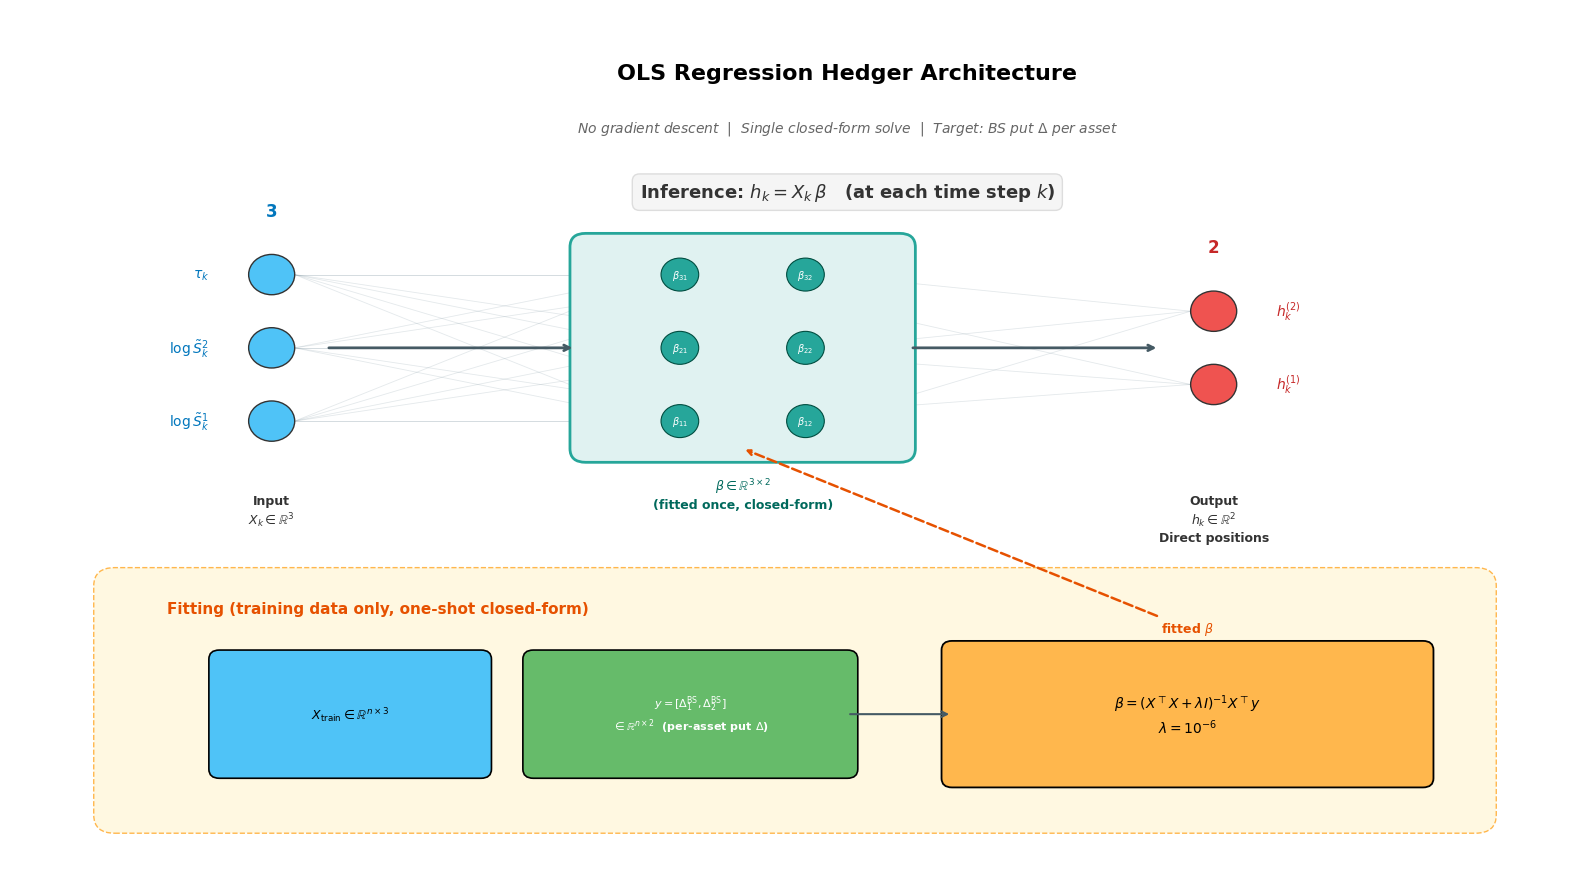

In [4]:
def draw_regression(save_path=None):
    """Draw the OLS Regression hedger with neuron-level diagram.
    
    Simple: 3 input neurons -> beta matrix (3x2) -> 2 output neurons.
    Also shows the fitting stage below.
    """
    fig, ax = plt.subplots(figsize=(16, 9))

    neuron_r = 0.22
    c_input = '#4FC3F7'
    c_beta = '#26A69A'
    c_output = '#EF5350'
    c_target = '#66BB6A'
    c_fit = '#FFB74D'
    c_conn = '#78909C'

    # ===== INFERENCE (top half) =====
    inf_label_y = 7.5
    ax.text(7.5, inf_label_y, 'Inference: $h_k = X_k \\, \\beta$   (at each time step $k$)',
            ha='center', va='center', fontsize=13, fontweight='bold', color='#333',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#F5F5F5',
                     edgecolor='#DDD', linewidth=1.0))

    # Input neurons (3)
    inp_x = 2.0
    inp_ys = [5.0, 5.8, 6.6]
    inp_labels = ['$\\log \\tilde{S}_k^1$', '$\\log \\tilde{S}_k^2$', '$\\tau_k$']
    for y, lbl in zip(inp_ys, inp_labels):
        circle = plt.Circle((inp_x, y), neuron_r, facecolor=c_input,
                           edgecolor='#333', linewidth=1.0, zorder=3)
        ax.add_patch(circle)
        ax.text(inp_x - 0.6, y, lbl, ha='right', va='center', fontsize=10,
                fontweight='bold', color='#0277BD')

    ax.text(inp_x, 4.2, 'Input\n$X_k \\in \\mathbb{R}^3$', ha='center', va='top',
            fontsize=9, fontweight='bold', color='#333')
    ax.text(inp_x, inp_ys[-1] + 0.6, '3', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='#0277BD')

    # Beta matrix (shown as a grid of weights)
    beta_x = 6.5
    beta_y_center = 5.8
    beta_w = 3.0
    beta_h = 2.2

    # Draw beta matrix box
    beta_box = FancyBboxPatch((beta_x - beta_w/2, beta_y_center - beta_h/2),
                               beta_w, beta_h, boxstyle='round,pad=0.15',
                               facecolor='#E0F2F1', edgecolor=c_beta,
                               linewidth=2.0, zorder=1)
    ax.add_patch(beta_box)

    # Draw weight circles inside beta (3 rows x 2 cols)
    beta_xs = [beta_x - 0.6, beta_x + 0.6]
    beta_ys = [5.0, 5.8, 6.6]
    for row in range(3):
        for col in range(2):
            bx = beta_xs[col]
            by = beta_ys[row]
            wc = plt.Circle((bx, by), 0.18, facecolor=c_beta,
                           edgecolor='#004D40', linewidth=0.8, zorder=3)
            ax.add_patch(wc)
            ax.text(bx, by, f'$\\beta_{{{row+1}{col+1}}}$', ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold', zorder=4)

    ax.text(beta_x, beta_y_center - beta_h/2 - 0.3,
            '$\\beta \\in \\mathbb{R}^{3 \\times 2}$\n(fitted once, closed-form)',
            ha='center', va='top', fontsize=9, fontweight='bold', color='#00695C')

    # Connections: input -> beta weights
    for iy in inp_ys:
        for col in range(2):
            for row in range(3):
                ax.plot([inp_x + neuron_r, beta_xs[col] - 0.18],
                        [iy, beta_ys[row]],
                        color=c_conn, linewidth=0.6, alpha=0.2, zorder=0)

    # Output neurons (2)
    out_x = 11.0
    out_ys = [5.4, 6.2]
    out_labels = ['$h_k^{(1)}$', '$h_k^{(2)}$']
    for y, lbl in zip(out_ys, out_labels):
        circle = plt.Circle((out_x, y), neuron_r, facecolor=c_output,
                           edgecolor='#333', linewidth=1.0, zorder=3)
        ax.add_patch(circle)
        ax.text(out_x + 0.6, y, lbl, ha='left', va='center', fontsize=10,
                fontweight='bold', color='#C62828')

    ax.text(out_x, 4.2, 'Output\n$h_k \\in \\mathbb{R}^2$\nDirect positions',
            ha='center', va='top', fontsize=9, fontweight='bold', color='#333')
    ax.text(out_x, out_ys[-1] + 0.6, '2', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='#C62828')

    # Connections: beta weights -> output
    for col in range(2):
        for row in range(3):
            ax.plot([beta_xs[col] + 0.18, out_x - neuron_r],
                    [beta_ys[row], out_ys[col]],
                    color=c_conn, linewidth=0.6, alpha=0.2, zorder=0)

    # Arrows
    ax.annotate('', xy=(beta_x - beta_w/2 - 0.1, beta_y_center),
                xytext=(inp_x + neuron_r + 0.3, beta_y_center),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=2))
    ax.annotate('', xy=(out_x - neuron_r - 0.3, beta_y_center),
                xytext=(beta_x + beta_w/2 + 0.1, beta_y_center),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=2))

    # ===== FITTING STAGE (bottom half) =====
    fit_y = 1.5
    fit_bg = FancyBboxPatch((0.5, fit_y - 0.8), 13, 2.5, boxstyle='round,pad=0.2',
                            facecolor='#FFF8E1', edgecolor='#FFB74D',
                            linewidth=1.0, linestyle='--', zorder=0)
    ax.add_patch(fit_bg)

    ax.text(1.0, fit_y + 1.4, 'Fitting (training data only, one-shot closed-form)',
            fontsize=11, fontweight='bold', color='#E65100')

    # Training X
    tx_box = FancyBboxPatch((1.5, fit_y - 0.3), 2.5, 1.2, boxstyle='round,pad=0.1',
                            facecolor=c_input, edgecolor='black', linewidth=1.2, zorder=1)
    ax.add_patch(tx_box)
    ax.text(2.75, fit_y + 0.3, '$X_{\\mathrm{train}} \\in \\mathbb{R}^{n \\times 3}$',
            ha='center', va='center', fontsize=9, fontweight='bold')

    # Target y
    ty_box = FancyBboxPatch((4.5, fit_y - 0.3), 3.0, 1.2, boxstyle='round,pad=0.1',
                            facecolor=c_target, edgecolor='black', linewidth=1.2, zorder=1)
    ax.add_patch(ty_box)
    ax.text(6.0, fit_y + 0.3,
            '$y = [\\Delta_1^{\\mathrm{BS}}, \\Delta_2^{\\mathrm{BS}}]$\n'
            '$\\in \\mathbb{R}^{n \\times 2}$  (per-asset put $\\Delta$)',
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

    # Arrow
    ax.annotate('', xy=(8.5, fit_y + 0.3), xytext=(7.5, fit_y + 0.3),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.5))

    # OLS formula
    ols_box = FancyBboxPatch((8.5, fit_y - 0.4), 4.5, 1.4, boxstyle='round,pad=0.1',
                             facecolor=c_fit, edgecolor='black', linewidth=1.3, zorder=1)
    ax.add_patch(ols_box)
    ax.text(10.75, fit_y + 0.3,
            '$\\beta = (X^\\top X + \\lambda I)^{-1} X^\\top y$\n'
            '$\\lambda = 10^{-6}$',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Arrow from OLS up to beta matrix
    ax.annotate('fitted $\\beta$',
                xy=(beta_x, beta_y_center - beta_h/2),
                xytext=(10.75, fit_y + 0.9 + 0.3),
                fontsize=9, color='#E65100', ha='center', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#E65100', lw=1.8, linestyle='--'))

    # --- Title ---
    ax.text(7.5, 8.8, 'OLS Regression Hedger Architecture',
            ha='center', va='center', fontsize=16, fontweight='bold')
    ax.text(7.5, 8.2,
            'No gradient descent  |  Single closed-form solve  |  '
            'Target: BS put $\\Delta$ per asset',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    ax.set_xlim(-0.5, 14.5)
    ax.set_ylim(0.0, 9.5)
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_regression('Figures/regression_architecture.png')

## 4. Side-by-Side Comparison

Summary of the three hedging models used in this thesis.

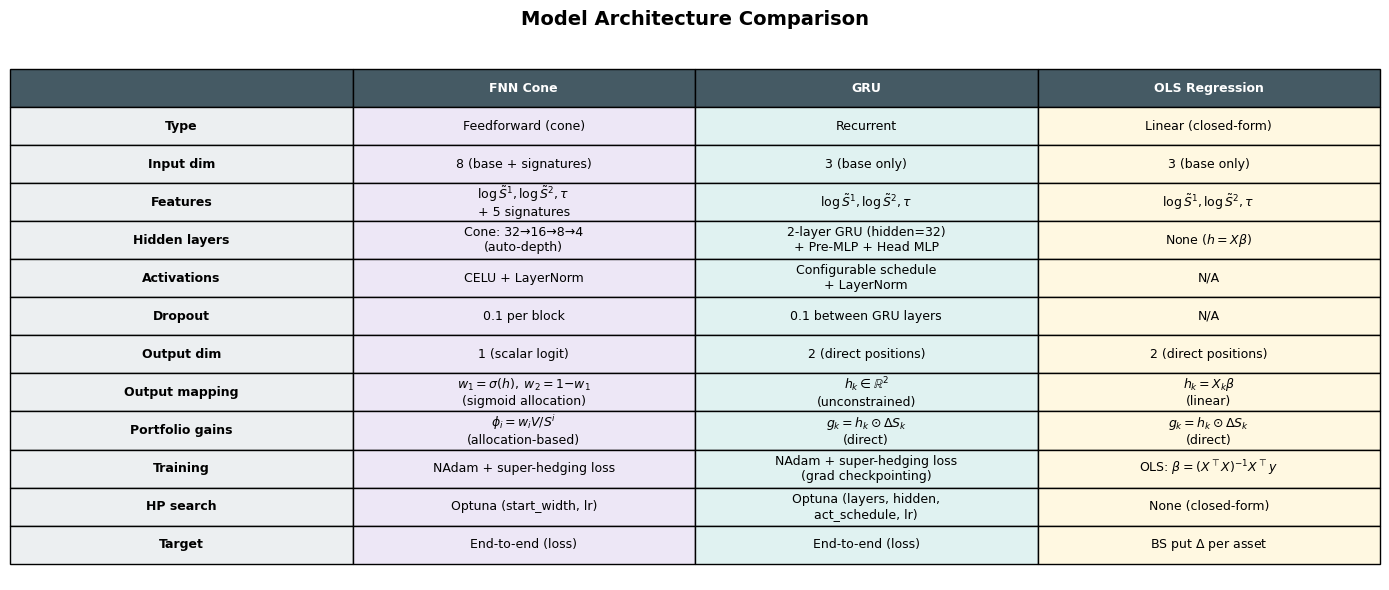

In [5]:
def draw_comparison_table(save_path=None):
    """Summary comparison figure of all three architectures."""
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')

    headers = ['', 'FNN Cone', 'GRU', 'OLS Regression']
    rows = [
        ['Type', 'Feedforward (cone)', 'Recurrent', 'Linear (closed-form)'],
        ['Input dim', '8 (base + signatures)', '3 (base only)', '3 (base only)'],
        ['Features', '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$\n+ 5 signatures',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$'],
        ['Hidden layers', 'Cone: 32→16→8→4\n(auto-depth)', '2-layer GRU (hidden=32)\n+ Pre-MLP + Head MLP',
         'None ($h = X\\beta$)'],
        ['Activations', 'CELU + LayerNorm', 'Configurable schedule\n+ LayerNorm', 'N/A'],
        ['Dropout', '0.1 per block', '0.1 between GRU layers', 'N/A'],
        ['Output dim', '1 (scalar logit)', '2 (direct positions)', '2 (direct positions)'],
        ['Output mapping', '$w_1 = \\sigma(h),\\; w_2 = 1{-}w_1$\n(sigmoid allocation)',
         '$h_k \\in \\mathbb{R}^2$\n(unconstrained)', '$h_k = X_k \\beta$\n(linear)'],
        ['Portfolio gains', '$\\phi_i = w_i V / S^i$\n(allocation-based)',
         '$g_k = h_k \\odot \\Delta S_k$\n(direct)', '$g_k = h_k \\odot \\Delta S_k$\n(direct)'],
        ['Training', 'NAdam + super-hedging loss', 'NAdam + super-hedging loss\n(grad checkpointing)',
         'OLS: $\\beta = (X^\\top X)^{-1}X^\\top y$'],
        ['HP search', 'Optuna (start_width, lr)', 'Optuna (layers, hidden,\nact_schedule, lr)',
         'None (closed-form)'],
        ['Target', 'End-to-end (loss)', 'End-to-end (loss)', 'BS put $\\Delta$ per asset'],
    ]

    table = ax.table(
        cellText=rows,
        colLabels=headers,
        loc='center',
        cellLoc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 2.0)

    # Style header
    for j in range(len(headers)):
        cell = table[0, j]
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#455A64')

    # Column colours (light tints)
    col_colours = {1: '#EDE7F6', 2: '#E0F2F1', 3: '#FFF8E1'}  # purple, teal, amber tints

    # Style row labels and cells
    for i in range(1, len(rows) + 1):
        cell = table[i, 0]
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('#ECEFF1')
        for j in range(1, len(headers)):
            cell = table[i, j]
            cell.set_facecolor(col_colours.get(j, '#FFFFFF'))

    ax.set_title('Model Architecture Comparison', fontsize=14, fontweight='bold', pad=20)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_comparison_table('Figures/model_comparison_table.png')

## 5. Super-Hedging Loss Function

The asymmetric loss penalises **under-hedging** (shortfall) $10\times$ more than **over-hedging**:

$$\mathcal{L} = \underbrace{\lambda_s \cdot \mathbb{E}[s]}_{\text{mean shortfall}} + \underbrace{\lambda_o \cdot \mathbb{E}[o]}_{\text{mean over-hedge}} + \underbrace{\lambda_s \cdot \text{CVaR}_{0.95}(s)}_{\text{tail shortfall}}$$

where $s = \max(\tilde{H} - V_T, 0)$, $o = \max(V_T - \tilde{H}, 0)$, $\lambda_s = 10$, $\lambda_o = 1$.

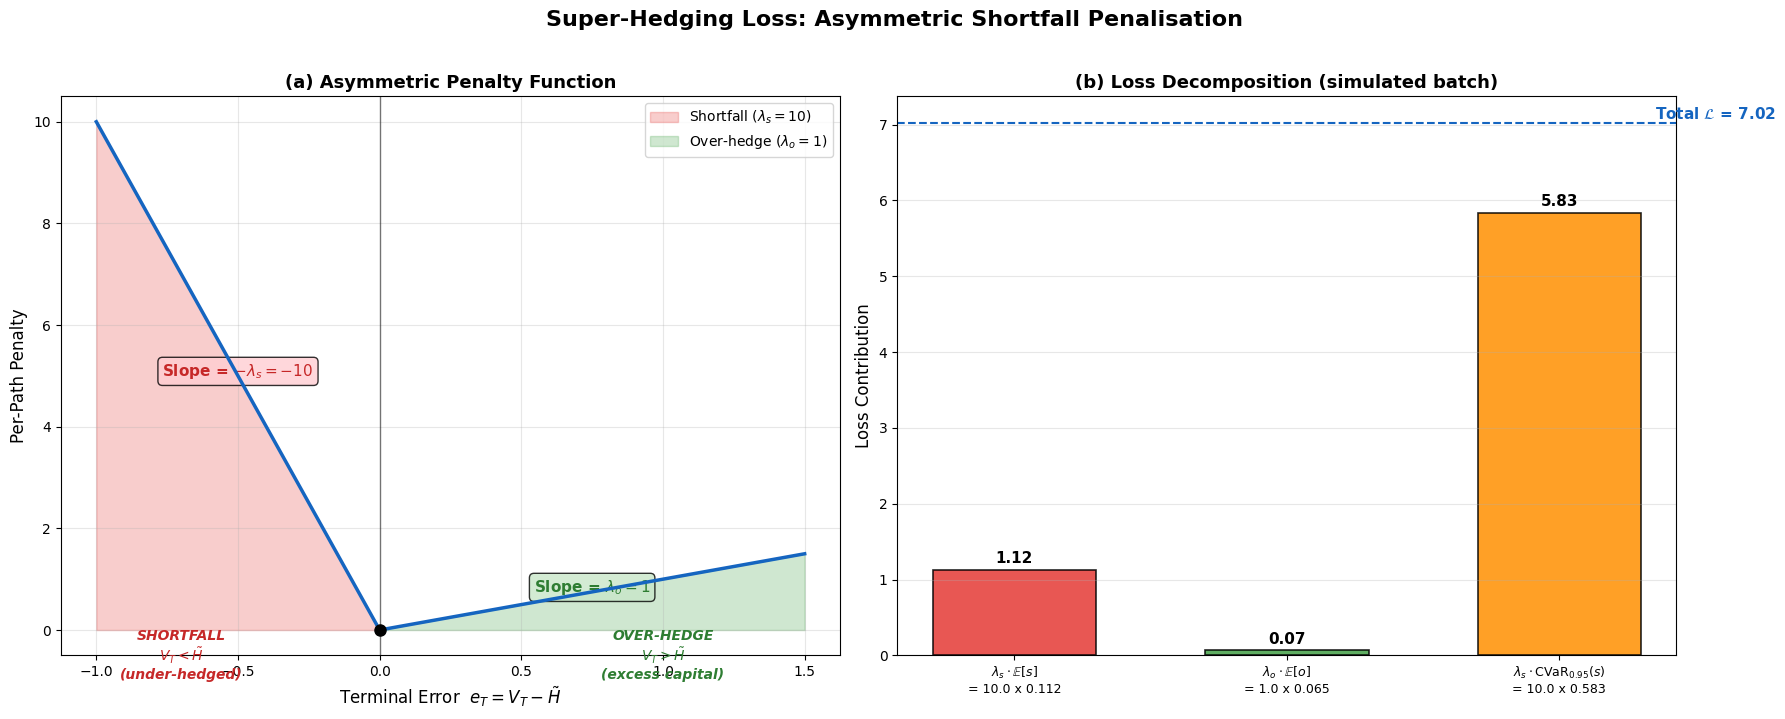

In [6]:
def draw_super_hedging_loss(save_path=None):
    """Visualize the asymmetric super-hedging loss function.
    
    Shows L(e) as a function of terminal error e = V_T - H_tilde.
    Left side (shortfall): steep penalty (lambda_short=10).
    Right side (over-hedge): gentle penalty (lambda_over=1).
    Also shows CVaR tail component.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # --- Panel A: Asymmetric penalty function ---
    ax = axes[0]
    e = np.linspace(-1.0, 1.5, 500)
    lambda_s, lambda_o = 10.0, 1.0
    
    shortfall = np.maximum(-e, 0)   # s = max(H - V_T, 0)
    over_hedge = np.maximum(e, 0)   # o = max(V_T - H, 0)
    
    # Per-path penalty: lambda_s * s + lambda_o * o
    penalty = lambda_s * shortfall + lambda_o * over_hedge
    
    # Also show individual components
    ax.fill_between(e[e <= 0], 0, penalty[e <= 0], alpha=0.25, color='#E53935',
                    label=f'Shortfall ($\\lambda_s={lambda_s:.0f}$)')
    ax.fill_between(e[e >= 0], 0, penalty[e >= 0], alpha=0.25, color='#43A047',
                    label=f'Over-hedge ($\\lambda_o={lambda_o:.0f}$)')
    
    ax.plot(e, penalty, color='#1565C0', linewidth=2.5, zorder=5)
    
    # Mark the kink at e=0
    ax.plot(0, 0, 'ko', markersize=8, zorder=6)
    ax.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    
    # Annotate slopes
    ax.annotate(f'Slope = $-\\lambda_s = -{lambda_s:.0f}$',
                xy=(-0.5, lambda_s * 0.5), fontsize=11, color='#C62828',
                fontweight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFCDD2', alpha=0.8))
    ax.annotate(f'Slope = $\\lambda_o = {lambda_o:.0f}$',
                xy=(0.75, lambda_o * 0.75), fontsize=11, color='#2E7D32',
                fontweight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#C8E6C9', alpha=0.8))
    
    # Labels
    ax.set_xlabel('Terminal Error  $e_T = V_T - \\tilde{H}$', fontsize=12)
    ax.set_ylabel('Per-Path Penalty', fontsize=12)
    ax.set_title('(a) Asymmetric Penalty Function', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Zone labels
    ax.text(-0.7, -0.5, 'SHORTFALL\n$V_T < \\tilde{H}$\n(under-hedged)',
            ha='center', va='center', fontsize=10, color='#C62828',
            fontweight='bold', style='italic')
    ax.text(1.0, -0.5, 'OVER-HEDGE\n$V_T > \\tilde{H}$\n(excess capital)',
            ha='center', va='center', fontsize=10, color='#2E7D32',
            fontweight='bold', style='italic')
    
    # --- Panel B: Full loss decomposition ---
    ax2 = axes[1]
    
    # Simulate a batch of terminal errors (realistic-looking)
    np.random.seed(42)
    n = 2000
    errors = np.concatenate([
        np.random.normal(0.05, 0.15, int(n * 0.7)),   # most paths slightly over-hedged
        np.random.normal(-0.3, 0.2, int(n * 0.3)),     # some paths under-hedged
    ])
    
    s = np.maximum(-errors, 0)
    o = np.maximum(errors, 0)
    
    # Sort for CVaR visualisation
    s_sorted = np.sort(s)[::-1]
    k_cvar = max(1, int(0.05 * n))  # top 5%
    
    # Bar chart of loss components
    mean_s = s.mean()
    mean_o = o.mean()
    cvar_s = s_sorted[:k_cvar].mean()
    
    components = [
        f'$\\lambda_s \\cdot \\mathbb{{E}}[s]$\n= {lambda_s} x {mean_s:.3f}',
        f'$\\lambda_o \\cdot \\mathbb{{E}}[o]$\n= {lambda_o} x {mean_o:.3f}',
        f'$\\lambda_s \\cdot \\mathrm{{CVaR}}_{{0.95}}(s)$\n= {lambda_s} x {cvar_s:.3f}',
    ]
    values = [lambda_s * mean_s, lambda_o * mean_o, lambda_s * cvar_s]
    colours = ['#E53935', '#43A047', '#FF8F00']
    
    bars = ax2.bar(range(3), values, color=colours, edgecolor='black',
                   linewidth=1.2, alpha=0.85, width=0.6)
    
    # Value labels on bars
    for bar, val in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.set_xticks(range(3))
    ax2.set_xticklabels(components, fontsize=9)
    ax2.set_ylabel('Loss Contribution', fontsize=12)
    ax2.set_title('(b) Loss Decomposition (simulated batch)', fontsize=13, fontweight='bold')
    
    total = sum(values)
    ax2.axhline(total, color='#1565C0', linestyle='--', linewidth=1.5)
    ax2.text(2.35, total + 0.05, f'Total $\\mathcal{{L}}$ = {total:.2f}',
            fontsize=11, fontweight='bold', color='#1565C0')
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    # --- Main title ---
    fig.suptitle('Super-Hedging Loss: Asymmetric Shortfall Penalisation',
                 fontsize=16, fontweight='bold', y=1.02)
    
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_super_hedging_loss('Figures/super_hedging_loss.png')

## 6. Portfolio Dynamics: Sigmoid Allocation vs Direct Positions

Two distinct portfolio update rules used by the hedging models:

**FNN (sigmoid allocation)**: $w_1 = \sigma(h_k)$, $\phi_i = w_i V_k / \tilde{S}_k^i$, then $V_{k+1} = V_k + \sum_i \phi_i \Delta \tilde{S}_k^i$

**GRU / Regression (direct positions)**: $h_k \in \mathbb{R}^2$, gains $g_k = h_k \odot \Delta \tilde{S}_k$, then $V_T = V_0 + \sum_k \sum_i g_k^{(i)}$

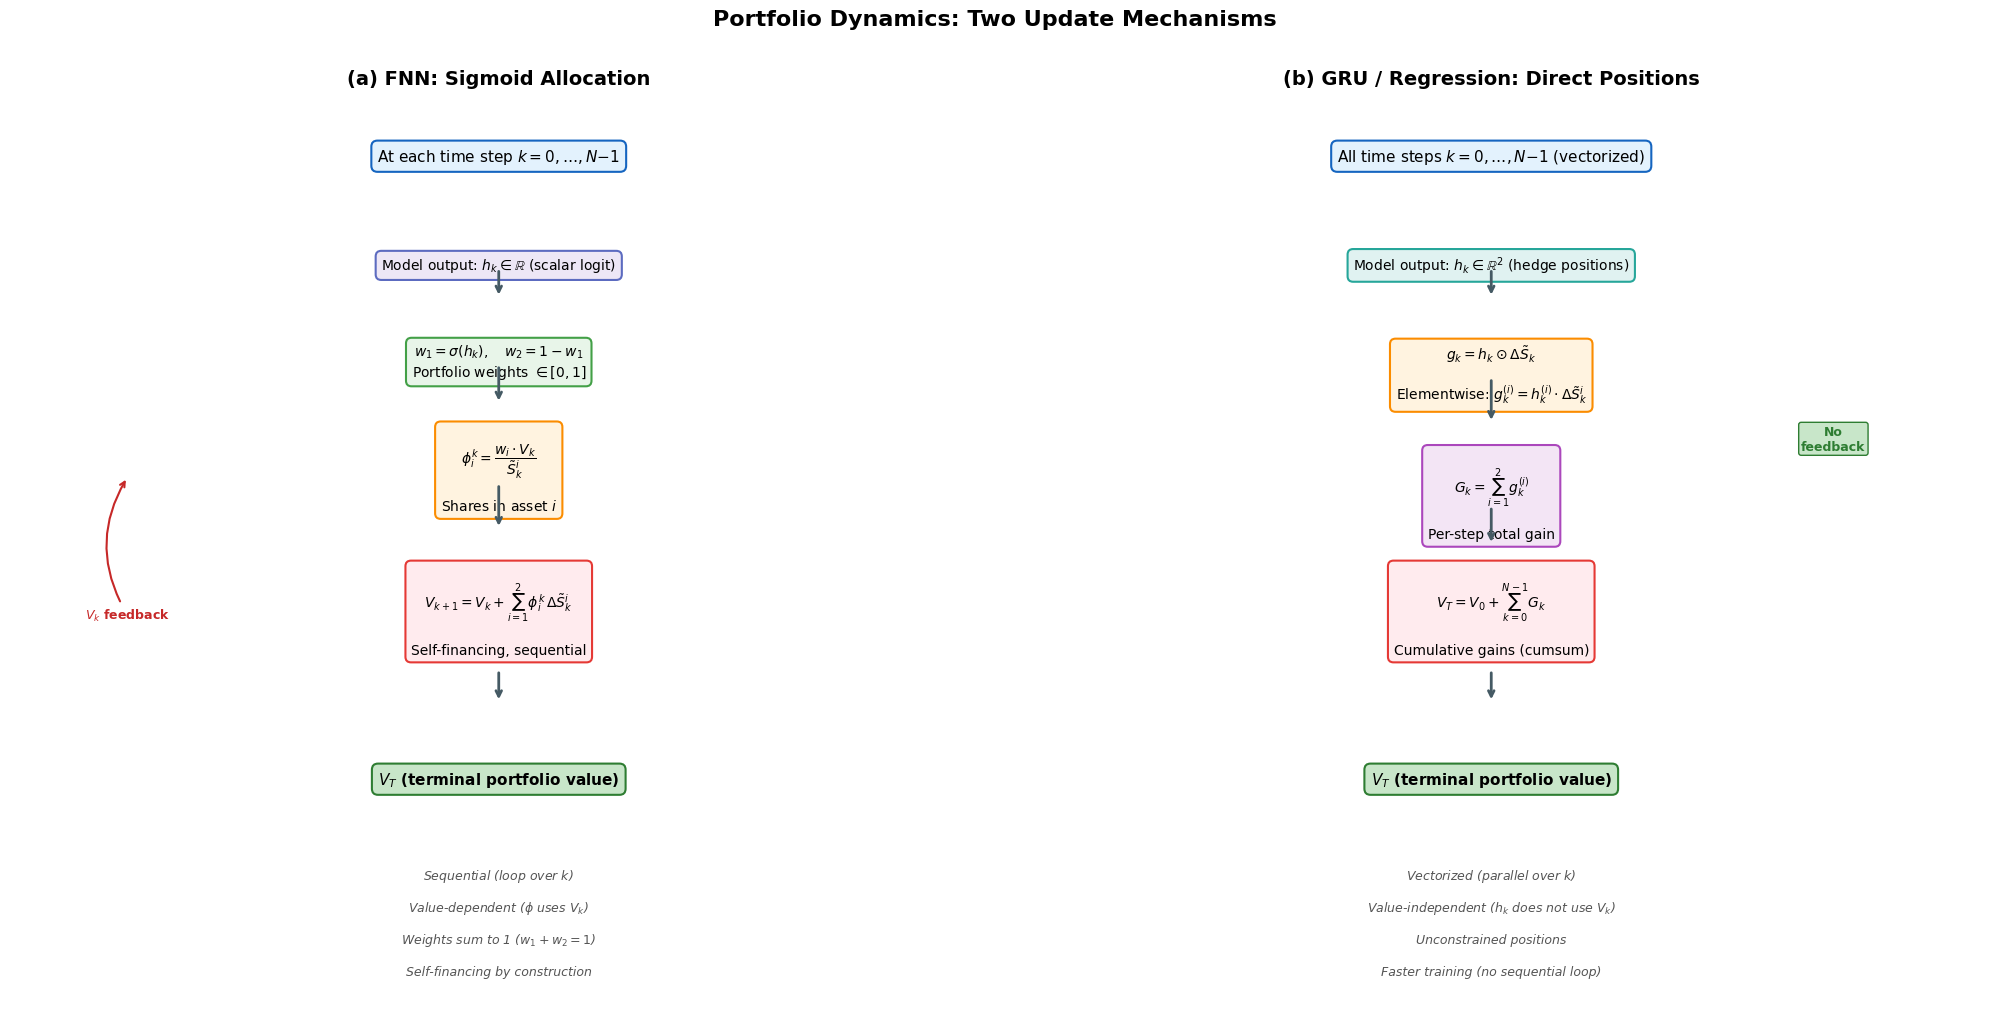

In [7]:
def draw_portfolio_dynamics(save_path=None):
    """Side-by-side comparison of the two portfolio update mechanisms.
    
    Left: FNN sigmoid allocation (sequential, value-dependent).
    Right: GRU/Regression direct positions (vectorized, value-independent).
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    box_kwargs = dict(boxstyle='round,pad=0.4', linewidth=1.5)
    arrow_kwargs = dict(arrowstyle='->', lw=2.0)
    
    # ===== LEFT PANEL: FNN Sigmoid Allocation =====
    ax = axes[0]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 14)
    ax.axis('off')
    ax.set_title('(a) FNN: Sigmoid Allocation', fontsize=14, fontweight='bold', pad=15)
    
    # Time step box
    ax.text(5, 13.2, 'At each time step $k = 0, \\ldots, N{-}1$',
            ha='center', va='center', fontsize=11,
            bbox=dict(facecolor='#E3F2FD', edgecolor='#1565C0', **box_kwargs))
    
    # Model output
    ax.text(5, 11.5, 'Model output: $h_k \\in \\mathbb{R}$ (scalar logit)',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#EDE7F6', edgecolor='#5C6BC0', **box_kwargs))
    ax.annotate('', xy=(5, 11.5 - 0.5), xytext=(5, 11.5 - 0.05),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Sigmoid
    ax.text(5, 10.0, '$w_1 = \\sigma(h_k), \\quad w_2 = 1 - w_1$\nPortfolio weights $\\in [0, 1]$',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#E8F5E9', edgecolor='#43A047', **box_kwargs))
    ax.annotate('', xy=(5, 10.0 - 0.65), xytext=(5, 10.0 - 0.05),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Shares
    ax.text(5, 8.2, '$\\phi_i^k = \\dfrac{w_i \\cdot V_k}{\\tilde{S}_k^i}$\n\nShares in asset $i$',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#FFF3E0', edgecolor='#FB8C00', **box_kwargs))
    ax.annotate('', xy=(5, 8.2 - 0.8), xytext=(5, 8.2 - 0.1),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Portfolio update
    ax.text(5, 6.0, '$V_{k+1} = V_k + \\sum_{i=1}^{2} \\phi_i^k \\, \\Delta\\tilde{S}_k^i$\n\nSelf-financing, sequential',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#FFEBEE', edgecolor='#E53935', **box_kwargs))
    
    # Feedback arrow (V_k depends on previous step)
    ax.annotate('$V_k$ feedback',
                xy=(1.2, 8.2), xytext=(1.2, 6.0),
                ha='center', fontsize=9, color='#C62828', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#C62828', lw=1.5,
                               connectionstyle='arc3,rad=-0.3'))
    
    # Terminal value
    ax.annotate('', xy=(5, 4.2 + 0.5), xytext=(5, 6.0 - 0.8),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    ax.text(5, 3.5, '$V_T$ (terminal portfolio value)',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(facecolor='#C8E6C9', edgecolor='#2E7D32', **box_kwargs))
    
    # Key properties
    props = [
        'Sequential (loop over $k$)',
        'Value-dependent ($\\phi$ uses $V_k$)',
        'Weights sum to 1 ($w_1 + w_2 = 1$)',
        'Self-financing by construction',
    ]
    for i, p in enumerate(props):
        ax.text(5, 2.0 - i * 0.5, p, ha='center', va='center',
                fontsize=9, color='#555', style='italic')
    
    # ===== RIGHT PANEL: GRU/Regression Direct Positions =====
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 14)
    ax2.axis('off')
    ax2.set_title('(b) GRU / Regression: Direct Positions', fontsize=14, fontweight='bold', pad=15)
    
    # Time step box
    ax2.text(5, 13.2, 'All time steps $k = 0, \\ldots, N{-}1$ (vectorized)',
            ha='center', va='center', fontsize=11,
            bbox=dict(facecolor='#E3F2FD', edgecolor='#1565C0', **box_kwargs))
    
    # Model output
    ax2.text(5, 11.5, 'Model output: $h_k \\in \\mathbb{R}^2$ (hedge positions)',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#E0F2F1', edgecolor='#26A69A', **box_kwargs))
    ax2.annotate('', xy=(5, 11.5 - 0.5), xytext=(5, 11.5 - 0.05),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Gains
    ax2.text(5, 9.8, '$g_k = h_k \\odot \\Delta\\tilde{S}_k$\n\n'
             'Elementwise: $g_k^{(i)} = h_k^{(i)} \\cdot \\Delta\\tilde{S}_k^i$',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#FFF3E0', edgecolor='#FB8C00', **box_kwargs))
    ax2.annotate('', xy=(5, 9.8 - 0.75), xytext=(5, 9.8 - 0.05),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Sum over assets
    ax2.text(5, 7.8, '$G_k = \\sum_{i=1}^{2} g_k^{(i)}$\n\nPer-step total gain',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#F3E5F5', edgecolor='#AB47BC', **box_kwargs))
    ax2.annotate('', xy=(5, 7.8 - 0.65), xytext=(5, 7.8 - 0.05),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    
    # Cumulative sum
    ax2.text(5, 6.0, '$V_T = V_0 + \\sum_{k=0}^{N-1} G_k$\n\nCumulative gains (cumsum)',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='#FFEBEE', edgecolor='#E53935', **box_kwargs))
    
    # No feedback arrow — direct
    ax2.text(8.5, 8.8, 'No\nfeedback', ha='center', va='center',
            fontsize=9, color='#2E7D32', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='#C8E6C9',
                     edgecolor='#2E7D32', linewidth=1.0))
    
    # Terminal value
    ax2.annotate('', xy=(5, 4.2 + 0.5), xytext=(5, 6.0 - 0.8),
                arrowprops=dict(color='#455A64', **arrow_kwargs))
    ax2.text(5, 3.5, '$V_T$ (terminal portfolio value)',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(facecolor='#C8E6C9', edgecolor='#2E7D32', **box_kwargs))
    
    # Key properties
    props2 = [
        'Vectorized (parallel over $k$)',
        'Value-independent ($h_k$ does not use $V_k$)',
        'Unconstrained positions',
        'Faster training (no sequential loop)',
    ]
    for i, p in enumerate(props2):
        ax2.text(5, 2.0 - i * 0.5, p, ha='center', va='center',
                fontsize=9, color='#555', style='italic')
    
    fig.suptitle('Portfolio Dynamics: Two Update Mechanisms',
                 fontsize=16, fontweight='bold', y=1.01)
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_portfolio_dynamics('Figures/portfolio_dynamics.png')

## 7. Experiment Pipeline

Full experimental workflow from market simulation to final evaluation. Each market model (GBM, Heston) runs through the same pipeline independently.

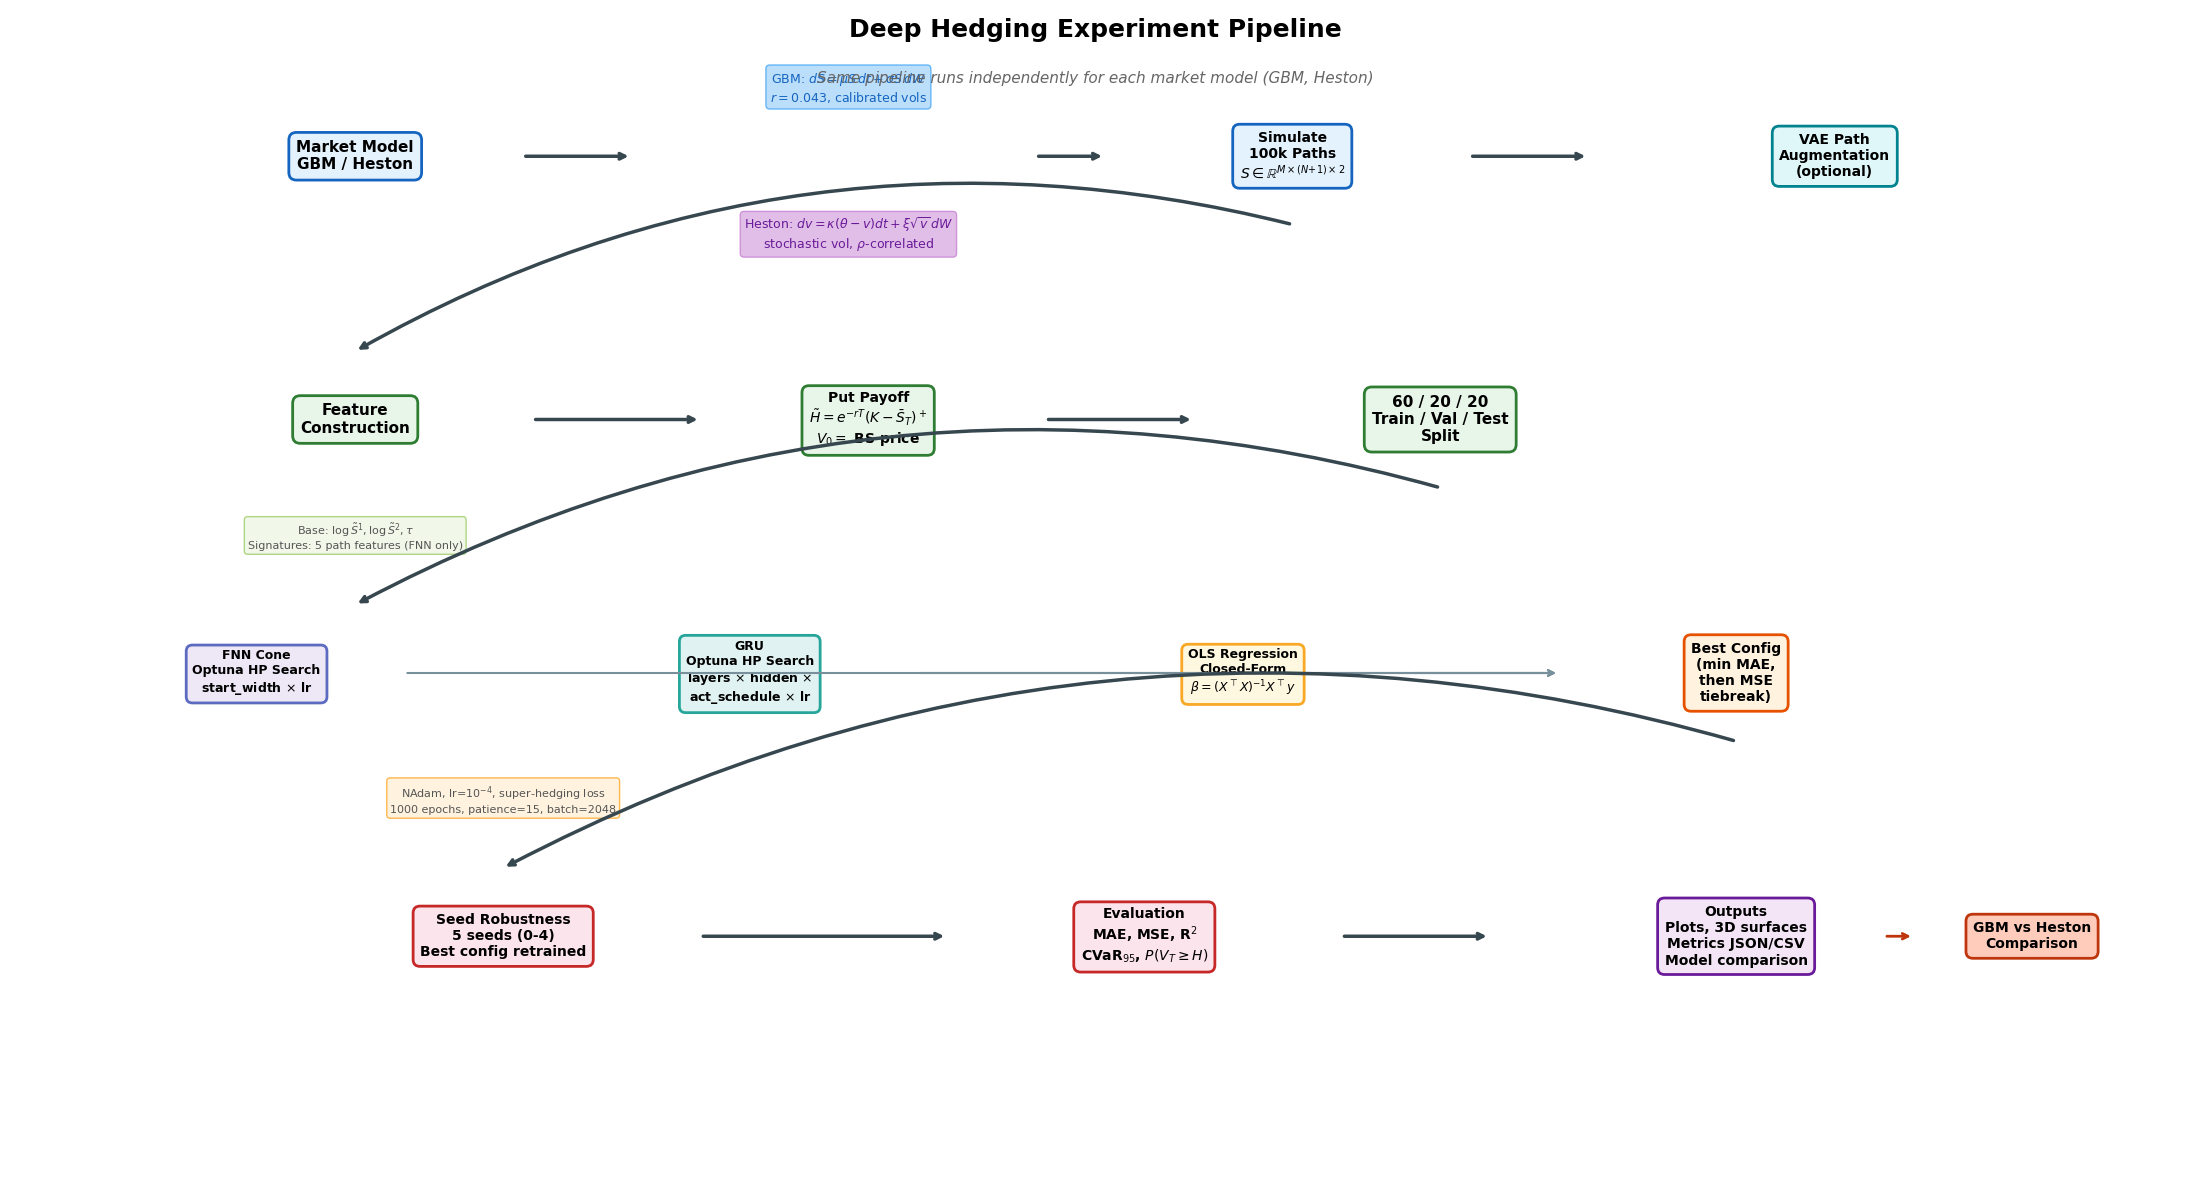

In [8]:
def draw_experiment_pipeline(save_path=None):
    """Draw the full experiment pipeline as a flowchart.
    
    GBM/Heston simulation -> VAE augmentation -> Feature construction ->
    Train/Val/Test split -> Optuna HP search -> Seed robustness -> Evaluation
    """
    fig, ax = plt.subplots(figsize=(22, 12))
    ax.set_xlim(0, 22)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    bkw = dict(boxstyle='round,pad=0.5', linewidth=2.0)
    akw = dict(arrowstyle='->', lw=2.5, color='#37474F')
    
    # Colours for different pipeline stages
    c_sim = '#E3F2FD'       # blue - simulation
    c_data = '#E8F5E9'      # green - data prep
    c_train = '#FFF3E0'     # orange - training
    c_eval = '#FCE4EC'      # pink - evaluation
    c_out = '#F3E5F5'       # purple - outputs
    
    e_sim = '#1565C0'
    e_data = '#2E7D32'
    e_train = '#E65100'
    e_eval = '#C62828'
    e_out = '#6A1B9A'
    
    # ===== ROW 1: Market Simulation =====
    y1 = 10.5
    
    # Market model selection
    ax.text(3.5, y1, 'Market Model\nGBM / Heston',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(facecolor=c_sim, edgecolor=e_sim, **bkw))
    
    ax.annotate('', xy=(6.3, y1), xytext=(5.2, y1), arrowprops=akw)
    
    # GBM params
    ax.text(8.5, y1 + 0.7, 'GBM: $dS = \\mu S\\,dt + \\sigma S\\,dW$\n'
            '$r=0.043$, calibrated vols',
            ha='center', va='center', fontsize=9, color='#1565C0',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#BBDEFB',
                     edgecolor='#64B5F6', linewidth=1.0))
    
    ax.text(8.5, y1 - 0.8, 'Heston: $dv = \\kappa(\\theta-v)dt + \\xi\\sqrt{v}\\,dW$\n'
            'stochastic vol, $\\rho$-correlated',
            ha='center', va='center', fontsize=9, color='#6A1B9A',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#E1BEE7',
                     edgecolor='#CE93D8', linewidth=1.0))
    
    # Path simulation
    ax.text(13.0, y1, 'Simulate\n100k Paths\n$S \\in \\mathbb{R}^{M \\times (N{+}1) \\times 2}$',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_sim, edgecolor=e_sim, **bkw))
    
    ax.annotate('', xy=(11.1, y1), xytext=(10.4, y1), arrowprops=akw)
    
    # VAE augmentation
    ax.annotate('', xy=(16.0, y1), xytext=(14.8, y1), arrowprops=akw)
    ax.text(18.5, y1, 'VAE Path\nAugmentation\n(optional)',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor='#E0F7FA', edgecolor='#00838F', **bkw))
    
    # ===== ROW 2: Data Preparation =====
    y2 = 7.8
    
    ax.annotate('', xy=(3.5, y2 + 0.7), xytext=(13.0, y1 - 0.7),
                arrowprops=dict(**akw, connectionstyle='arc3,rad=0.2'))
    
    # Feature construction
    ax.text(3.5, y2, 'Feature\nConstruction',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(facecolor=c_data, edgecolor=e_data, **bkw))
    
    # Feature details
    ax.text(3.5, y2 - 1.2,
            'Base: $\\log\\tilde{S}^1, \\log\\tilde{S}^2, \\tau$\n'
            'Signatures: 5 path features (FNN only)',
            ha='center', va='center', fontsize=8, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#F1F8E9',
                     edgecolor='#AED581', linewidth=1.0))
    
    ax.annotate('', xy=(7.0, y2), xytext=(5.3, y2), arrowprops=akw)
    
    # Payoff computation
    ax.text(8.7, y2, 'Put Payoff\n$\\tilde{H} = e^{-rT}(K - \\bar{S}_T)^+$\n'
            '$V_0 = $ BS price',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_data, edgecolor=e_data, **bkw))
    
    ax.annotate('', xy=(12.0, y2), xytext=(10.5, y2), arrowprops=akw)
    
    # Train/Val/Test split
    ax.text(14.5, y2, '60 / 20 / 20\nTrain / Val / Test\nSplit',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(facecolor=c_data, edgecolor=e_data, **bkw))
    
    # ===== ROW 3: Training =====
    y3 = 5.2
    
    ax.annotate('', xy=(3.5, y3 + 0.7), xytext=(14.5, y2 - 0.7),
                arrowprops=dict(**akw, connectionstyle='arc3,rad=0.2'))
    
    # FNN training
    ax.text(2.5, y3, 'FNN Cone\nOptuna HP Search\nstart_width $\\times$ lr',
            ha='center', va='center', fontsize=9, fontweight='bold',
            bbox=dict(facecolor='#EDE7F6', edgecolor='#5C6BC0', **bkw))
    
    # GRU training
    ax.text(7.5, y3, 'GRU\nOptuna HP Search\nlayers $\\times$ hidden $\\times$\nact_schedule $\\times$ lr',
            ha='center', va='center', fontsize=9, fontweight='bold',
            bbox=dict(facecolor='#E0F2F1', edgecolor='#26A69A', **bkw))
    
    # Regression
    ax.text(12.5, y3, 'OLS Regression\nClosed-Form\n$\\beta = (X^\\top X)^{-1}X^\\top y$',
            ha='center', va='center', fontsize=9, fontweight='bold',
            bbox=dict(facecolor='#FFF8E1', edgecolor='#F9A825', **bkw))
    
    # Training details
    ax.text(5.0, y3 - 1.3, 'NAdam, lr=$10^{-4}$, super-hedging loss\n'
            '1000 epochs, patience=15, batch=2048',
            ha='center', va='center', fontsize=8, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=c_train,
                     edgecolor='#FFB74D', linewidth=1.0))
    
    # Best config selection
    ax.text(17.5, y3, 'Best Config\n(min MAE,\nthen MSE\ntiebreak)',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_train, edgecolor=e_train, **bkw))
    
    for x_from in [4.0, 9.2, 14.2]:
        ax.annotate('', xy=(15.7, y3), xytext=(x_from, y3),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='#78909C'))
    
    # ===== ROW 4: Seed Robustness & Evaluation =====
    y4 = 2.5
    
    ax.annotate('', xy=(5.0, y4 + 0.7), xytext=(17.5, y3 - 0.7),
                arrowprops=dict(**akw, connectionstyle='arc3,rad=0.2'))
    
    # Seed robustness
    ax.text(5.0, y4, 'Seed Robustness\n5 seeds (0-4)\nBest config retrained',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_eval, edgecolor=e_eval, **bkw))
    
    ax.annotate('', xy=(9.5, y4), xytext=(7.0, y4), arrowprops=akw)
    
    # Evaluation
    ax.text(11.5, y4, 'Evaluation\nMAE, MSE, R$^2$\nCVaR$_{95}$, $P(V_T \\geq H)$',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_eval, edgecolor=e_eval, **bkw))
    
    ax.annotate('', xy=(15.0, y4), xytext=(13.5, y4), arrowprops=akw)
    
    # Outputs
    ax.text(17.5, y4, 'Outputs\nPlots, 3D surfaces\nMetrics JSON/CSV\nModel comparison',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=c_out, edgecolor=e_out, **bkw))
    
    # GBM vs Heston comparison arrow
    ax.text(20.5, y4, 'GBM vs Heston\nComparison',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor='#FFCCBC', edgecolor='#BF360C', **bkw))
    ax.annotate('', xy=(19.3, y4), xytext=(19.0, y4),
                arrowprops=dict(arrowstyle='->', lw=2.0, color='#BF360C'))
    
    # Title
    ax.text(11, 11.8, 'Deep Hedging Experiment Pipeline',
            ha='center', va='center', fontsize=18, fontweight='bold')
    ax.text(11, 11.3, 'Same pipeline runs independently for each market model (GBM, Heston)',
            ha='center', va='center', fontsize=11, color='#666', style='italic')
    
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_experiment_pipeline('Figures/experiment_pipeline.png')

## 8. GBM vs Heston: Market Model Comparison

Side-by-side comparison of the two market models used in the thesis. GBM assumes constant volatility; Heston allows stochastic volatility with mean reversion and leverage effects.

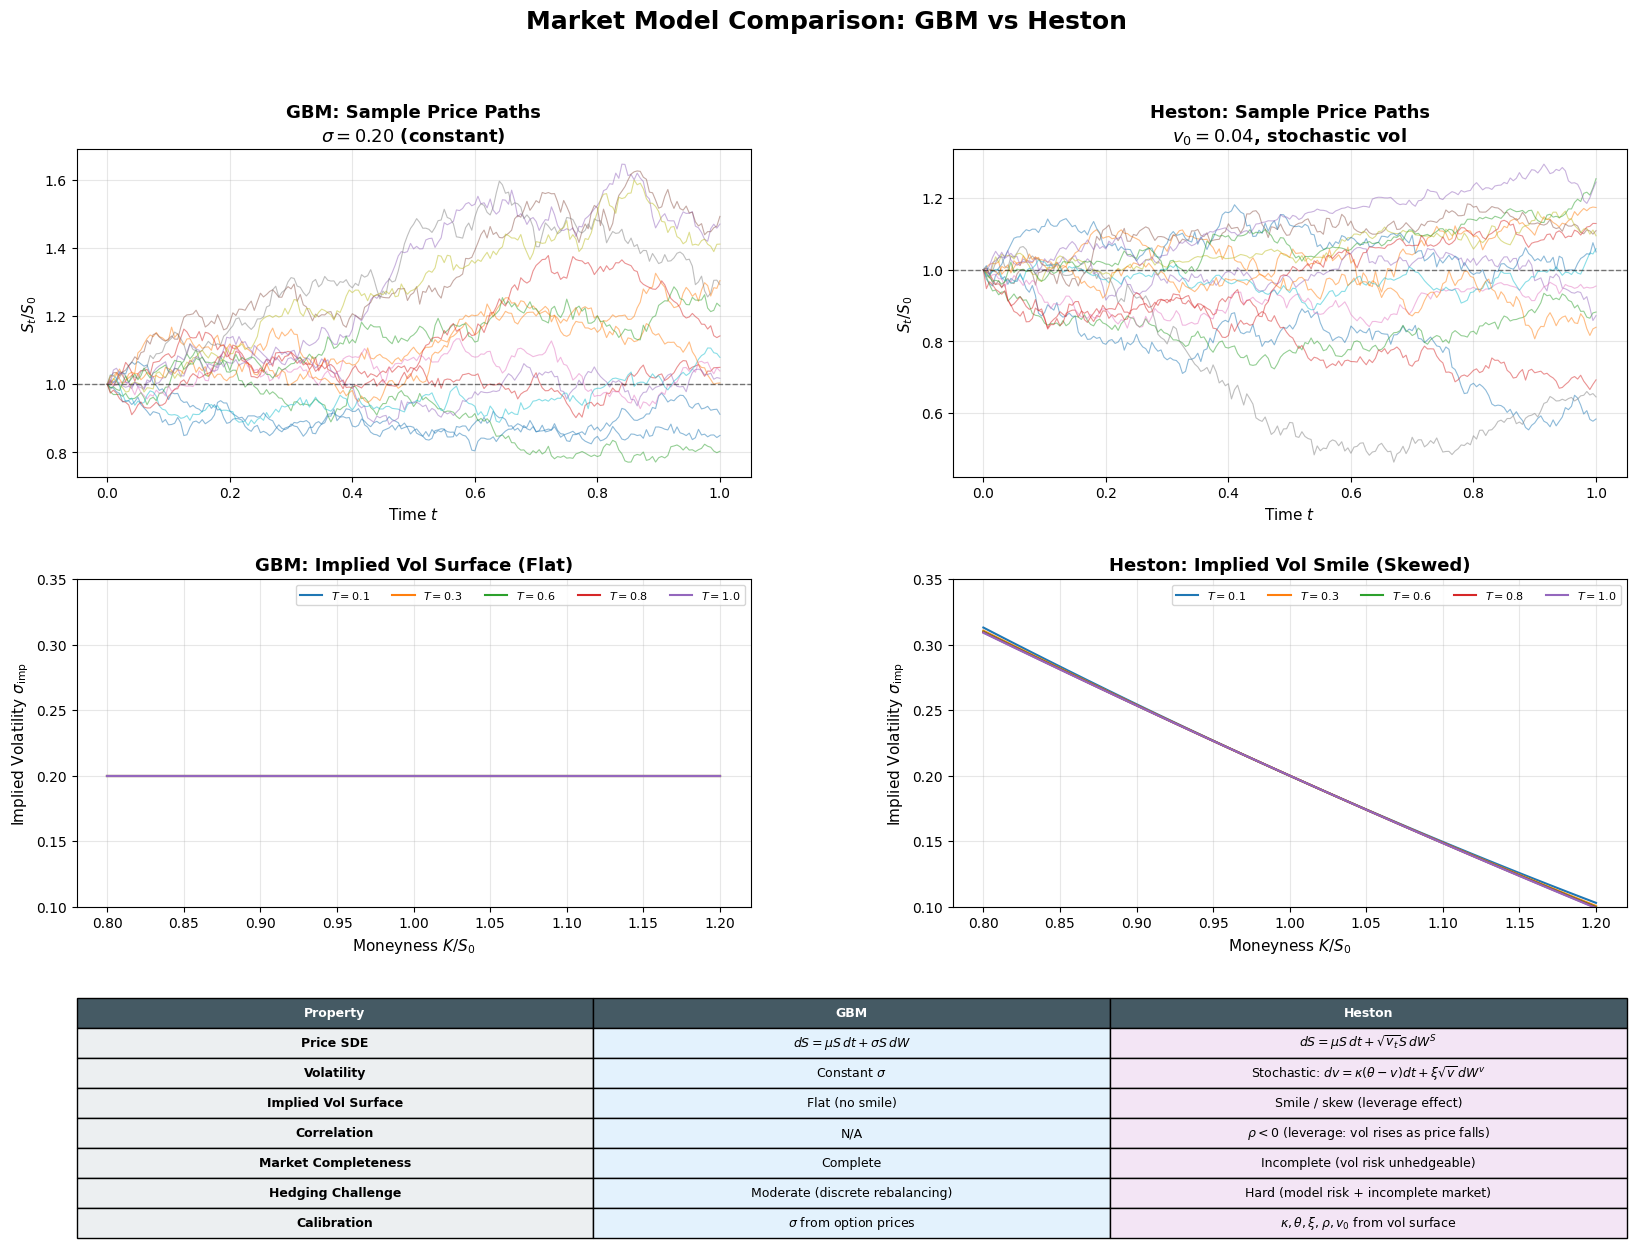

In [9]:
def draw_gbm_vs_heston(save_path=None):
    """Compare GBM and Heston market models visually.
    
    Left: GBM constant-vol sample paths and vol surface.
    Right: Heston stochastic-vol sample paths and vol surface.
    Bottom: comparison table of properties.
    """
    fig = plt.figure(figsize=(20, 14))
    
    # GridSpec: 2 rows x 2 cols on top, 1 wide row on bottom
    gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 0.8], hspace=0.35, wspace=0.3)
    
    np.random.seed(42)
    T, N, n_paths = 1.0, 200, 15
    dt = T / N
    t = np.linspace(0, T, N + 1)
    S0 = 1.0
    
    # ===== GBM sample paths =====
    ax_gbm = fig.add_subplot(gs[0, 0])
    mu, sigma_gbm = 0.043, 0.20
    
    for _ in range(n_paths):
        Z = np.random.randn(N)
        S = np.zeros(N + 1)
        S[0] = S0
        for i in range(N):
            S[i+1] = S[i] * np.exp((mu - 0.5*sigma_gbm**2)*dt + sigma_gbm*np.sqrt(dt)*Z[i])
        ax_gbm.plot(t, S, alpha=0.5, linewidth=0.8)
    
    ax_gbm.axhline(S0, color='black', linewidth=1, linestyle='--', alpha=0.5)
    ax_gbm.set_xlabel('Time $t$', fontsize=11)
    ax_gbm.set_ylabel('$S_t / S_0$', fontsize=11)
    ax_gbm.set_title('GBM: Sample Price Paths\n$\\sigma = 0.20$ (constant)', fontsize=13, fontweight='bold')
    ax_gbm.grid(True, alpha=0.3)
    
    # ===== Heston sample paths =====
    ax_hes = fig.add_subplot(gs[0, 1])
    kappa, theta, xi, rho = 2.0, 0.04, 0.3, -0.7
    v0 = 0.04
    
    for _ in range(n_paths):
        Z1 = np.random.randn(N)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(N)
        S = np.zeros(N + 1)
        v = np.zeros(N + 1)
        S[0] = S0
        v[0] = v0
        for i in range(N):
            v[i+1] = max(v[i] + kappa*(theta - v[i])*dt + xi*np.sqrt(max(v[i], 0)*dt)*Z2[i], 0)
            S[i+1] = S[i] * np.exp((mu - 0.5*v[i])*dt + np.sqrt(max(v[i], 0)*dt)*Z1[i])
        ax_hes.plot(t, S, alpha=0.5, linewidth=0.8)
    
    ax_hes.axhline(S0, color='black', linewidth=1, linestyle='--', alpha=0.5)
    ax_hes.set_xlabel('Time $t$', fontsize=11)
    ax_hes.set_ylabel('$S_t / S_0$', fontsize=11)
    ax_hes.set_title('Heston: Sample Price Paths\n$v_0 = 0.04$, stochastic vol', fontsize=13, fontweight='bold')
    ax_hes.grid(True, alpha=0.3)
    
    # ===== GBM vol "surface" (flat) =====
    ax_gvol = fig.add_subplot(gs[1, 0])
    moneyness = np.linspace(0.8, 1.2, 50)
    maturities = np.linspace(0.1, 1.0, 5)
    
    for mat in maturities:
        ax_gvol.plot(moneyness, np.full_like(moneyness, sigma_gbm),
                    linewidth=1.5, label=f'$T={mat:.1f}$')
    
    ax_gvol.set_xlabel('Moneyness $K/S_0$', fontsize=11)
    ax_gvol.set_ylabel('Implied Volatility $\\sigma_{\\mathrm{imp}}$', fontsize=11)
    ax_gvol.set_title('GBM: Implied Vol Surface (Flat)', fontsize=13, fontweight='bold')
    ax_gvol.set_ylim(0.10, 0.35)
    ax_gvol.legend(fontsize=8, ncol=5, loc='upper right')
    ax_gvol.grid(True, alpha=0.3)
    
    # ===== Heston implied vol smile =====
    ax_hvol = fig.add_subplot(gs[1, 1])
    
    for mat in maturities:
        # Approximate Heston smile shape (illustrative)
        atm_vol = np.sqrt(theta + (v0 - theta) * np.exp(-kappa * mat))
        skew = rho * xi / (2 * np.sqrt(theta))
        smile = atm_vol + skew * (moneyness - 1.0) + 0.1 * (moneyness - 1.0)**2 / mat**0.3
        smile = np.clip(smile, 0.05, 0.5)
        ax_hvol.plot(moneyness, smile, linewidth=1.5, label=f'$T={mat:.1f}$')
    
    ax_hvol.set_xlabel('Moneyness $K/S_0$', fontsize=11)
    ax_hvol.set_ylabel('Implied Volatility $\\sigma_{\\mathrm{imp}}$', fontsize=11)
    ax_hvol.set_title('Heston: Implied Vol Smile (Skewed)', fontsize=13, fontweight='bold')
    ax_hvol.set_ylim(0.10, 0.35)
    ax_hvol.legend(fontsize=8, ncol=5, loc='upper right')
    ax_hvol.grid(True, alpha=0.3)
    
    # ===== Bottom: Comparison table =====
    ax_tab = fig.add_subplot(gs[2, :])
    ax_tab.axis('off')
    
    headers = ['Property', 'GBM', 'Heston']
    rows = [
        ['Price SDE', '$dS = \\mu S\\,dt + \\sigma S\\,dW$',
         '$dS = \\mu S\\,dt + \\sqrt{v_t}S\\,dW^S$'],
        ['Volatility', 'Constant $\\sigma$', 'Stochastic: $dv = \\kappa(\\theta-v)dt + \\xi\\sqrt{v}\\,dW^v$'],
        ['Implied Vol Surface', 'Flat (no smile)', 'Smile / skew (leverage effect)'],
        ['Correlation', 'N/A', '$\\rho < 0$ (leverage: vol rises as price falls)'],
        ['Market Completeness', 'Complete', 'Incomplete (vol risk unhedgeable)'],
        ['Hedging Challenge', 'Moderate (discrete rebalancing)', 'Hard (model risk + incomplete market)'],
        ['Calibration', '$\\sigma$ from option prices', '$\\kappa, \\theta, \\xi, \\rho, v_0$ from vol surface'],
    ]
    
    table = ax_tab.table(
        cellText=rows,
        colLabels=headers,
        loc='center',
        cellLoc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 1.8)
    
    # Style header
    for j in range(3):
        cell = table[0, j]
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#455A64')
    
    # Style cells
    col_colours = {1: '#E3F2FD', 2: '#F3E5F5'}
    for i in range(1, len(rows) + 1):
        table[i, 0].set_text_props(fontweight='bold')
        table[i, 0].set_facecolor('#ECEFF1')
        for j in range(1, 3):
            table[i, j].set_facecolor(col_colours.get(j, '#FFFFFF'))
    
    fig.suptitle('Market Model Comparison: GBM vs Heston',
                 fontsize=18, fontweight='bold', y=0.98)
    
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_gbm_vs_heston('Figures/gbm_vs_heston_comparison.png')

## 9. Model Comparison: Histograms + Violin Plots

Comprehensive comparison plots using **simulated representative data** (actual data generated by the experiment pipeline). Includes:
- Terminal error distribution by model (histogram overlay + violin)
- Cross-market comparison: GBM vs Heston per model
- Metric comparison across models and markets
- Shortfall distribution analysis

In [10]:
import json, os, glob

def load_experiment_errors():
    """Load terminal errors from experiment outputs (GBM and Heston).
    
    Falls back to simulated data if experiment hasn't run yet.
    """
    base = os.getcwd()
    cross_path = os.path.join(base, 'outputs', 'cross_market', 'cross_market_errors.json')
    
    if os.path.exists(cross_path):
        with open(cross_path) as f:
            raw = json.load(f)
        data = {}
        for mkt, models in raw.items():
            data[mkt] = {m: np.array(e) for m, e in models.items()}
        return data
    
    # Try loading per-market metrics individually
    data = {}
    for mkt in ['gbm', 'heston']:
        mkt_dir = os.path.join(base, 'outputs', mkt, 'metrics_summary.json')
        if os.path.exists(mkt_dir):
            # We can construct from summary, but need actual errors
            # For now, use simulated data as placeholder
            pass
    
    # Fallback: generate representative simulated data
    print('No experiment outputs found — using simulated representative data.')
    np.random.seed(2026)
    n = 2000
    data = {
        'gbm': {
            'FNN': np.random.normal(0.02, 0.08, n),
            'GRU': np.random.normal(0.01, 0.04, n),
            'Regression': np.random.normal(0.03, 0.10, n),
        },
        'heston': {
            'FNN': np.random.normal(0.01, 0.12, n),
            'GRU': np.random.normal(0.005, 0.06, n),
            'Regression': np.random.normal(0.02, 0.15, n),
        },
    }
    return data

errors = load_experiment_errors()
models = list(errors.get('gbm', {}).keys())
markets = list(errors.keys())
print(f'Markets: {markets}')
print(f'Models: {models}')
for mkt in markets:
    for m in models:
        e = errors[mkt][m]
        print(f'  {mkt}/{m}: n={len(e)}, mean={e.mean():.4f}, std={e.std():.4f}')

Markets: ['gbm', 'heston']
Models: ['FNN', 'GRU', 'Regression']
  gbm/FNN: n=1000, mean=-0.0055, std=0.0893
  gbm/GRU: n=1000, mean=-0.0040, std=0.0211
  gbm/Regression: n=1000, mean=-0.0095, std=0.0920
  heston/FNN: n=1000, mean=-0.0003, std=0.1074
  heston/GRU: n=1000, mean=-0.0019, std=0.0252
  heston/Regression: n=1000, mean=0.0024, std=0.1039


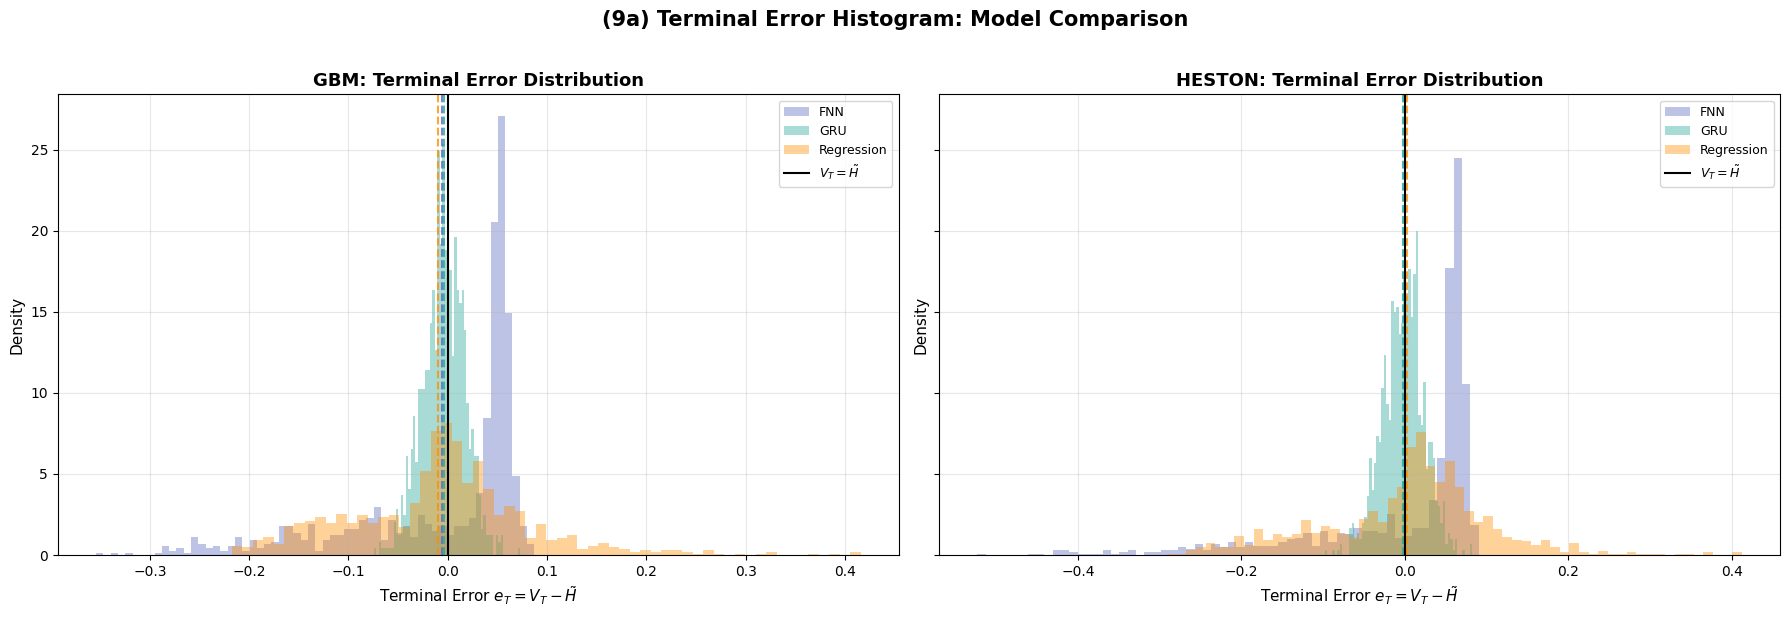

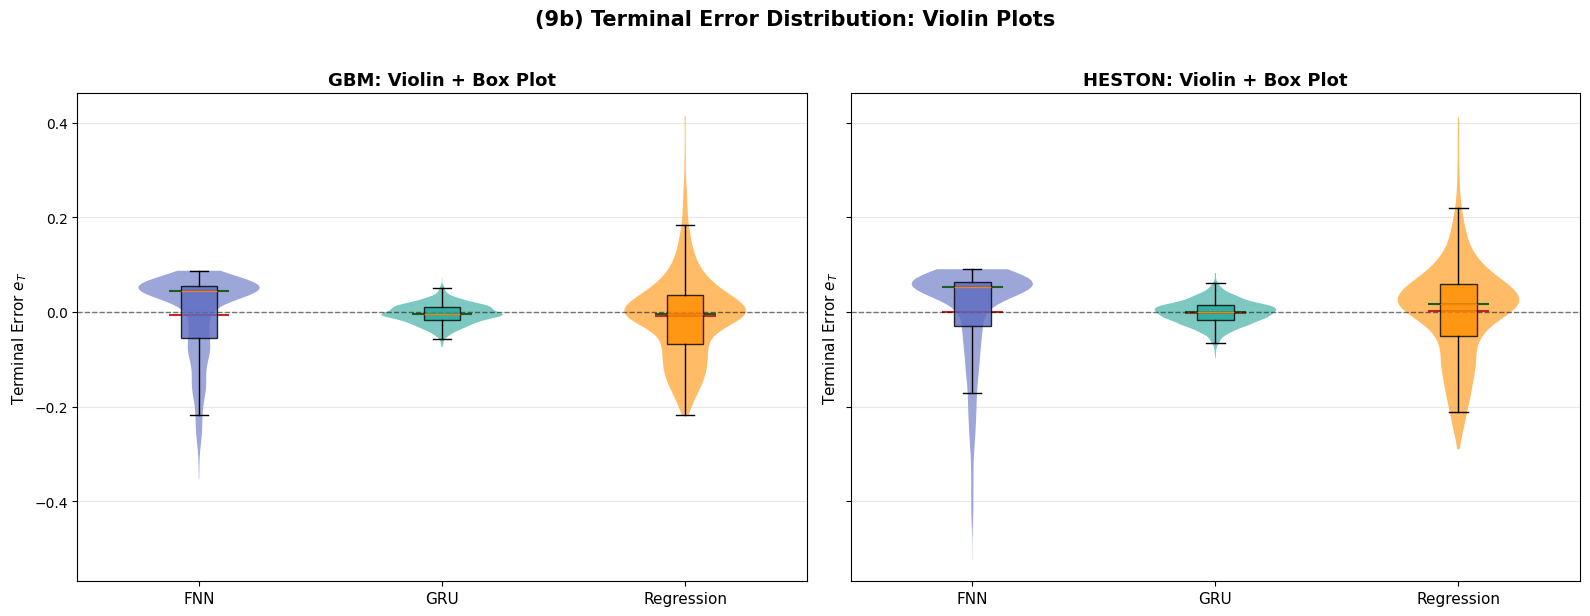

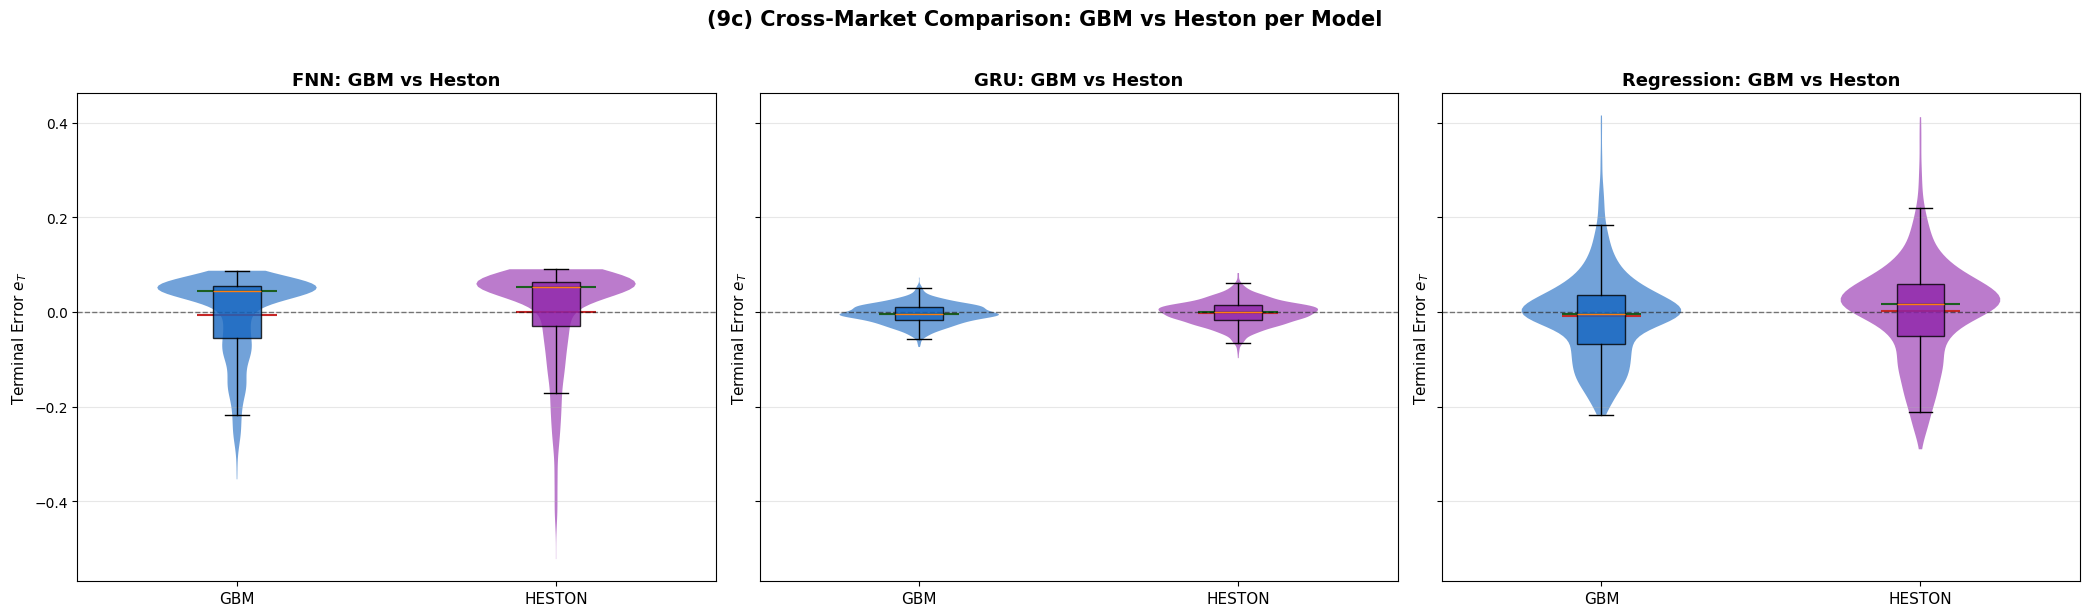

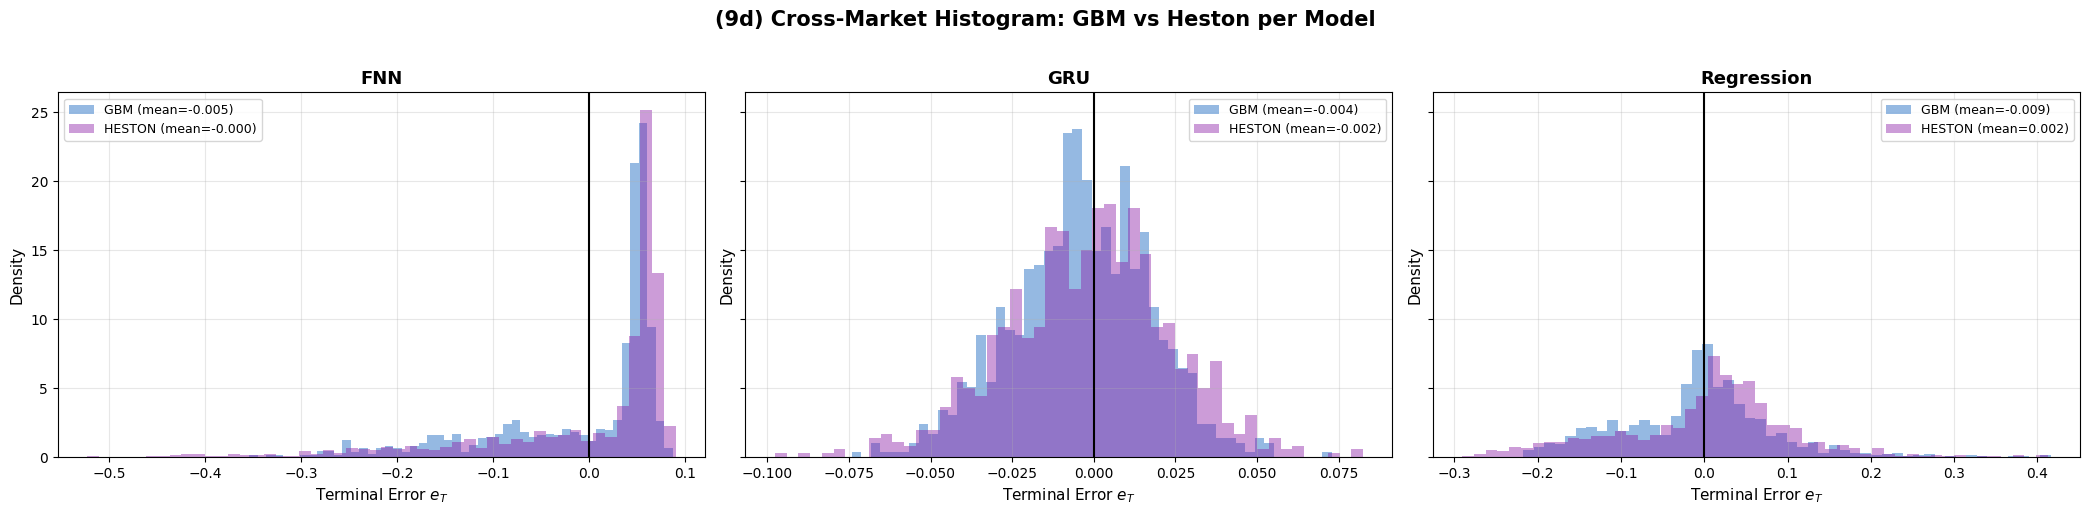

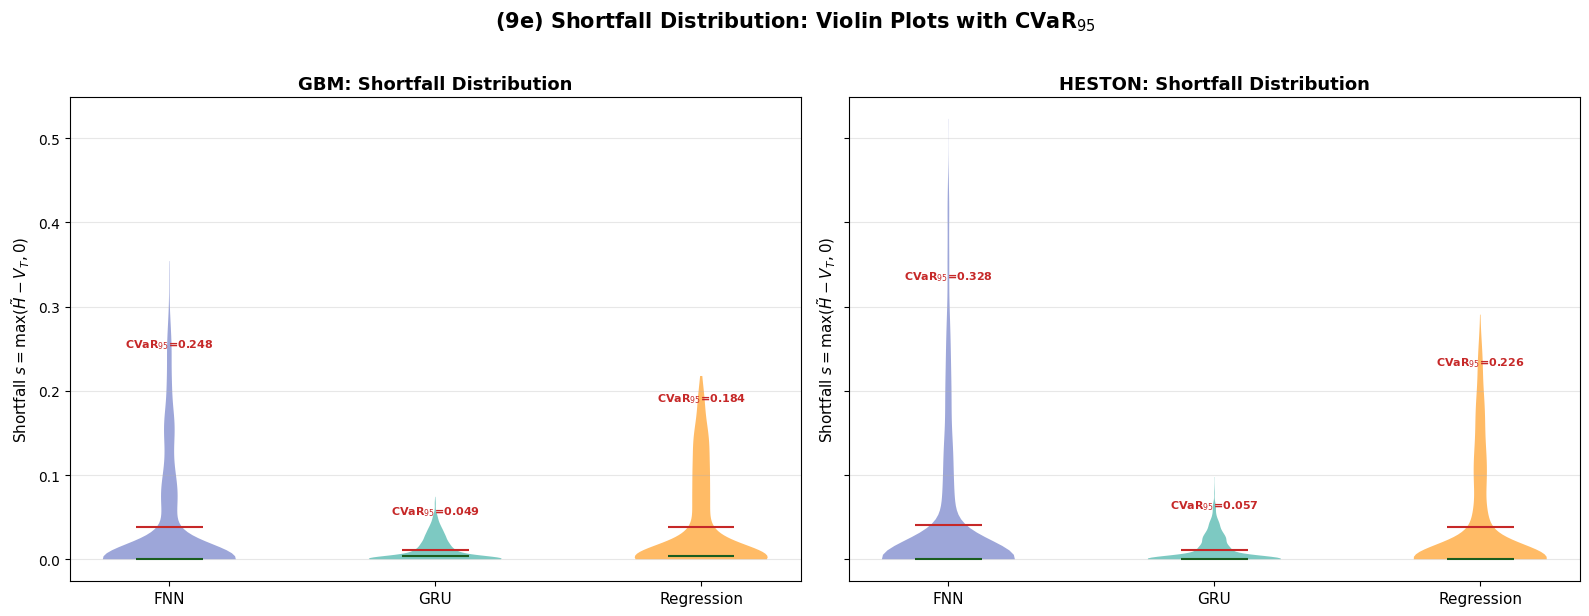

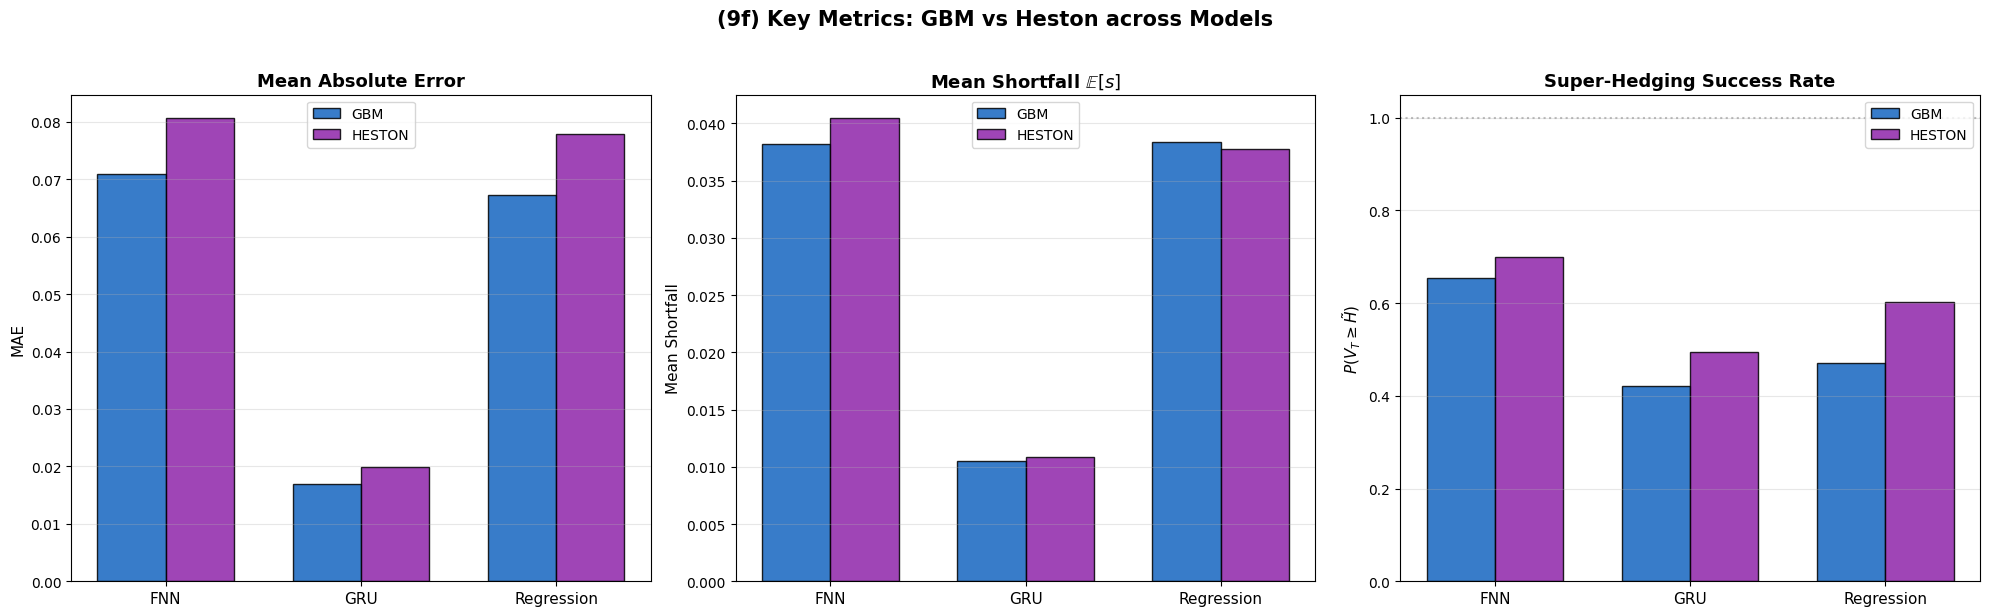

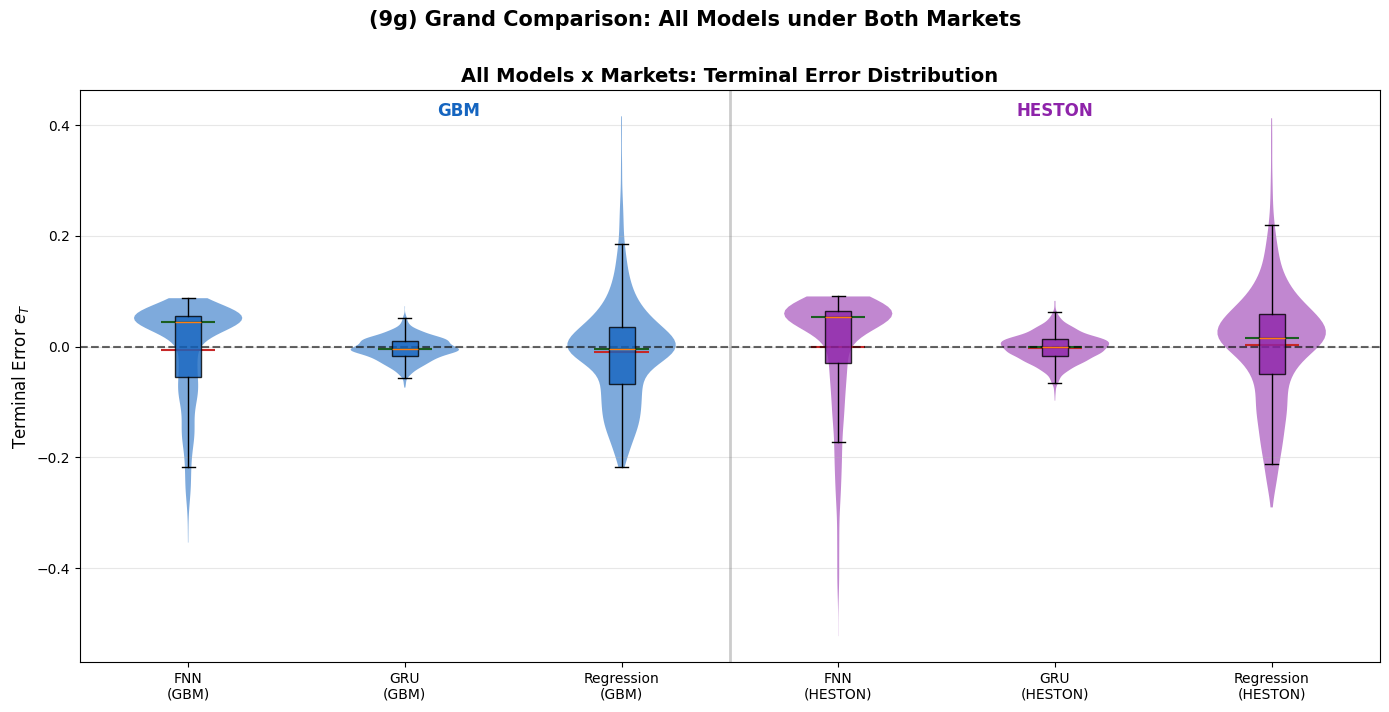

In [11]:
def plot_all_comparisons(errors, save_dir='Figures'):
    """Generate all histogram + violin comparison plots."""
    models = list(errors.get('gbm', errors.get('heston', {})).keys())
    markets = list(errors.keys())
    
    c_model = {'FNN': '#5C6BC0', 'GRU': '#26A69A', 'Regression': '#FF8F00'}
    c_market = {'gbm': '#1565C0', 'heston': '#8E24AA'}
    
    # ──────────────────────────────────────────────
    # FIGURE 9a: Terminal Error Histogram Overlay (per market)
    # ──────────────────────────────────────────────
    fig, axes = plt.subplots(1, len(markets), figsize=(9*len(markets), 6), sharey=True)
    if len(markets) == 1:
        axes = [axes]
    
    for ax, mkt in zip(axes, markets):
        for m in models:
            e = errors[mkt][m]
            ax.hist(e, bins=60, density=True, alpha=0.4, color=c_model[m], label=m)
            ax.axvline(e.mean(), color=c_model[m], linestyle='--', linewidth=1.5,
                      alpha=0.8)
        ax.axvline(0, color='black', linewidth=1.5, label='$V_T = \\tilde{H}$')
        ax.set_xlabel('Terminal Error $e_T = V_T - \\tilde{H}$', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'{mkt.upper()}: Terminal Error Distribution', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle('(9a) Terminal Error Histogram: Model Comparison', fontsize=15, fontweight='bold', y=1.02)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'comparison_histogram_by_model.png'), dpi=200, bbox_inches='tight')
    plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9b: Violin Plot — Terminal Errors by Model (per market)
    # ──────────────────────────────────────────────
    fig, axes = plt.subplots(1, len(markets), figsize=(8*len(markets), 6), sharey=True)
    if len(markets) == 1:
        axes = [axes]
    
    for ax, mkt in zip(axes, markets):
        data_list = [errors[mkt][m] for m in models]
        parts = ax.violinplot(data_list, positions=range(len(models)), showmeans=True,
                             showmedians=True, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(c_model[models[i]])
            pc.set_alpha(0.6)
        parts['cmeans'].set_color('#C62828')
        parts['cmedians'].set_color('#1B5E20')
        
        # Add box plot overlay for quartiles
        bp = ax.boxplot(data_list, positions=range(len(models)), widths=0.15,
                       patch_artist=True, showfliers=False, zorder=5)
        for i, patch in enumerate(bp['boxes']):
            patch.set_facecolor(c_model[models[i]])
            patch.set_alpha(0.8)
        
        ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, fontsize=11)
        ax.set_ylabel('Terminal Error $e_T$', fontsize=11)
        ax.set_title(f'{mkt.upper()}: Violin + Box Plot', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle('(9b) Terminal Error Distribution: Violin Plots', fontsize=15, fontweight='bold', y=1.02)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'comparison_violin_by_model.png'), dpi=200, bbox_inches='tight')
    plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9c: Cross-Market Violin — Same model, GBM vs Heston
    # ──────────────────────────────────────────────
    if len(markets) >= 2:
        fig, axes = plt.subplots(1, len(models), figsize=(7*len(models), 6), sharey=True)
        if len(models) == 1:
            axes = [axes]
        
        for ax, m in zip(axes, models):
            data_list = [errors[mkt][m] for mkt in markets]
            parts = ax.violinplot(data_list, positions=range(len(markets)), showmeans=True,
                                 showmedians=True, showextrema=False)
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(c_market[markets[i]])
                pc.set_alpha(0.6)
            parts['cmeans'].set_color('#C62828')
            parts['cmedians'].set_color('#1B5E20')
            
            bp = ax.boxplot(data_list, positions=range(len(markets)), widths=0.15,
                           patch_artist=True, showfliers=False, zorder=5)
            for i, patch in enumerate(bp['boxes']):
                patch.set_facecolor(c_market[markets[i]])
                patch.set_alpha(0.8)
            
            ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
            ax.set_xticks(range(len(markets)))
            ax.set_xticklabels([mk.upper() for mk in markets], fontsize=11)
            ax.set_ylabel('Terminal Error $e_T$', fontsize=11)
            ax.set_title(f'{m}: GBM vs Heston', fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
        
        fig.suptitle('(9c) Cross-Market Comparison: GBM vs Heston per Model',
                     fontsize=15, fontweight='bold', y=1.02)
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, 'comparison_violin_cross_market.png'), dpi=200, bbox_inches='tight')
        plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9d: Cross-Market Histogram Overlay (per model)
    # ──────────────────────────────────────────────
    if len(markets) >= 2:
        fig, axes = plt.subplots(1, len(models), figsize=(7*len(models), 5), sharey=True)
        if len(models) == 1:
            axes = [axes]
        
        for ax, m in zip(axes, models):
            for mkt in markets:
                e = errors[mkt][m]
                ax.hist(e, bins=50, density=True, alpha=0.45, color=c_market[mkt],
                       label=f'{mkt.upper()} (mean={e.mean():.3f})')
            ax.axvline(0, color='black', linewidth=1.5)
            ax.set_xlabel('Terminal Error $e_T$', fontsize=11)
            ax.set_ylabel('Density', fontsize=11)
            ax.set_title(f'{m}', fontsize=13, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        fig.suptitle('(9d) Cross-Market Histogram: GBM vs Heston per Model',
                     fontsize=15, fontweight='bold', y=1.02)
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, 'comparison_histogram_cross_market.png'), dpi=200, bbox_inches='tight')
        plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9e: Shortfall Distribution Violin (per market)
    # ──────────────────────────────────────────────
    fig, axes = plt.subplots(1, len(markets), figsize=(8*len(markets), 6), sharey=True)
    if len(markets) == 1:
        axes = [axes]
    
    for ax, mkt in zip(axes, markets):
        shortfalls = [np.maximum(-errors[mkt][m], 0) for m in models]
        # Filter to only paths with shortfall > 0
        parts = ax.violinplot(shortfalls, positions=range(len(models)),
                             showmeans=True, showmedians=True, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(c_model[models[i]])
            pc.set_alpha(0.6)
        parts['cmeans'].set_color('#C62828')
        parts['cmedians'].set_color('#1B5E20')
        
        # Annotate CVaR95
        for i, m in enumerate(models):
            s = np.maximum(-errors[mkt][m], 0)
            s_sorted = np.sort(s)[::-1]
            k = max(1, int(0.05 * len(s)))
            cvar95 = s_sorted[:k].mean()
            ax.annotate(f'CVaR$_{{95}}$={cvar95:.3f}', xy=(i, cvar95),
                       fontsize=8, ha='center', va='bottom', color='#C62828',
                       fontweight='bold')
        
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, fontsize=11)
        ax.set_ylabel('Shortfall $s = \\max(\\tilde{H} - V_T, 0)$', fontsize=11)
        ax.set_title(f'{mkt.upper()}: Shortfall Distribution', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle('(9e) Shortfall Distribution: Violin Plots with CVaR$_{95}$',
                 fontsize=15, fontweight='bold', y=1.02)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'comparison_violin_shortfall.png'), dpi=200, bbox_inches='tight')
    plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9f: Grouped Metric Bar Chart (MAE, Shortfall, P(V_T>=H))
    # ──────────────────────────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # MAE
    ax = axes[0]
    x = np.arange(len(models))
    width = 0.35
    for i, mkt in enumerate(markets):
        maes = [np.abs(errors[mkt][m]).mean() for m in models]
        ax.bar(x + i * width - width/2 * (len(markets)-1), maes, width,
               label=mkt.upper(), color=c_market[mkt], alpha=0.85, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=11)
    ax.set_ylabel('MAE', fontsize=11)
    ax.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Mean Shortfall
    ax = axes[1]
    for i, mkt in enumerate(markets):
        shortfalls = [np.maximum(-errors[mkt][m], 0).mean() for m in models]
        ax.bar(x + i * width - width/2 * (len(markets)-1), shortfalls, width,
               label=mkt.upper(), color=c_market[mkt], alpha=0.85, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=11)
    ax.set_ylabel('Mean Shortfall', fontsize=11)
    ax.set_title('Mean Shortfall $\\mathbb{E}[s]$', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # P(V_T >= H)
    ax = axes[2]
    for i, mkt in enumerate(markets):
        probs = [(errors[mkt][m] >= 0).mean() for m in models]
        ax.bar(x + i * width - width/2 * (len(markets)-1), probs, width,
               label=mkt.upper(), color=c_market[mkt], alpha=0.85, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=11)
    ax.set_ylabel('$P(V_T \\geq \\tilde{H})$', fontsize=11)
    ax.set_title('Super-Hedging Success Rate', fontsize=13, fontweight='bold')
    ax.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle('(9f) Key Metrics: GBM vs Heston across Models',
                 fontsize=15, fontweight='bold', y=1.02)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'comparison_metrics_bars.png'), dpi=200, bbox_inches='tight')
    plt.show()
    
    # ──────────────────────────────────────────────
    # FIGURE 9g: Combined 6-Model Violin (all market-model combos)
    # ──────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(14, 7))
    
    all_data = []
    all_labels = []
    all_colours = []
    for mkt in markets:
        for m in models:
            all_data.append(errors[mkt][m])
            all_labels.append(f'{m}\n({mkt.upper()})')
            # Blend model + market colour
            all_colours.append(c_market[mkt])
    
    positions = range(len(all_data))
    parts = ax.violinplot(all_data, positions=positions, showmeans=True,
                         showmedians=True, showextrema=False)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(all_colours[i])
        pc.set_alpha(0.55)
    parts['cmeans'].set_color('#C62828')
    parts['cmedians'].set_color('#1B5E20')
    
    bp = ax.boxplot(all_data, positions=positions, widths=0.12,
                   patch_artist=True, showfliers=False, zorder=5)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(all_colours[i])
        patch.set_alpha(0.8)
    
    ax.axhline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.6)
    ax.set_xticks(positions)
    ax.set_xticklabels(all_labels, fontsize=10)
    ax.set_ylabel('Terminal Error $e_T$', fontsize=12)
    ax.set_title('All Models x Markets: Terminal Error Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add market separator
    if len(markets) >= 2:
        sep_x = len(models) - 0.5
        ax.axvline(sep_x, color='gray', linewidth=2, linestyle='-', alpha=0.4)
        ax.text(sep_x/2, ax.get_ylim()[1] * 0.9, 'GBM', ha='center',
               fontsize=12, fontweight='bold', color=c_market['gbm'])
        ax.text(sep_x + len(models)/2, ax.get_ylim()[1] * 0.9, 'HESTON', ha='center',
               fontsize=12, fontweight='bold', color=c_market.get('heston', '#8E24AA'))
    
    fig.suptitle('(9g) Grand Comparison: All Models under Both Markets',
                 fontsize=15, fontweight='bold', y=1.01)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, 'comparison_grand_violin.png'), dpi=200, bbox_inches='tight')
    plt.show()

plot_all_comparisons(errors)